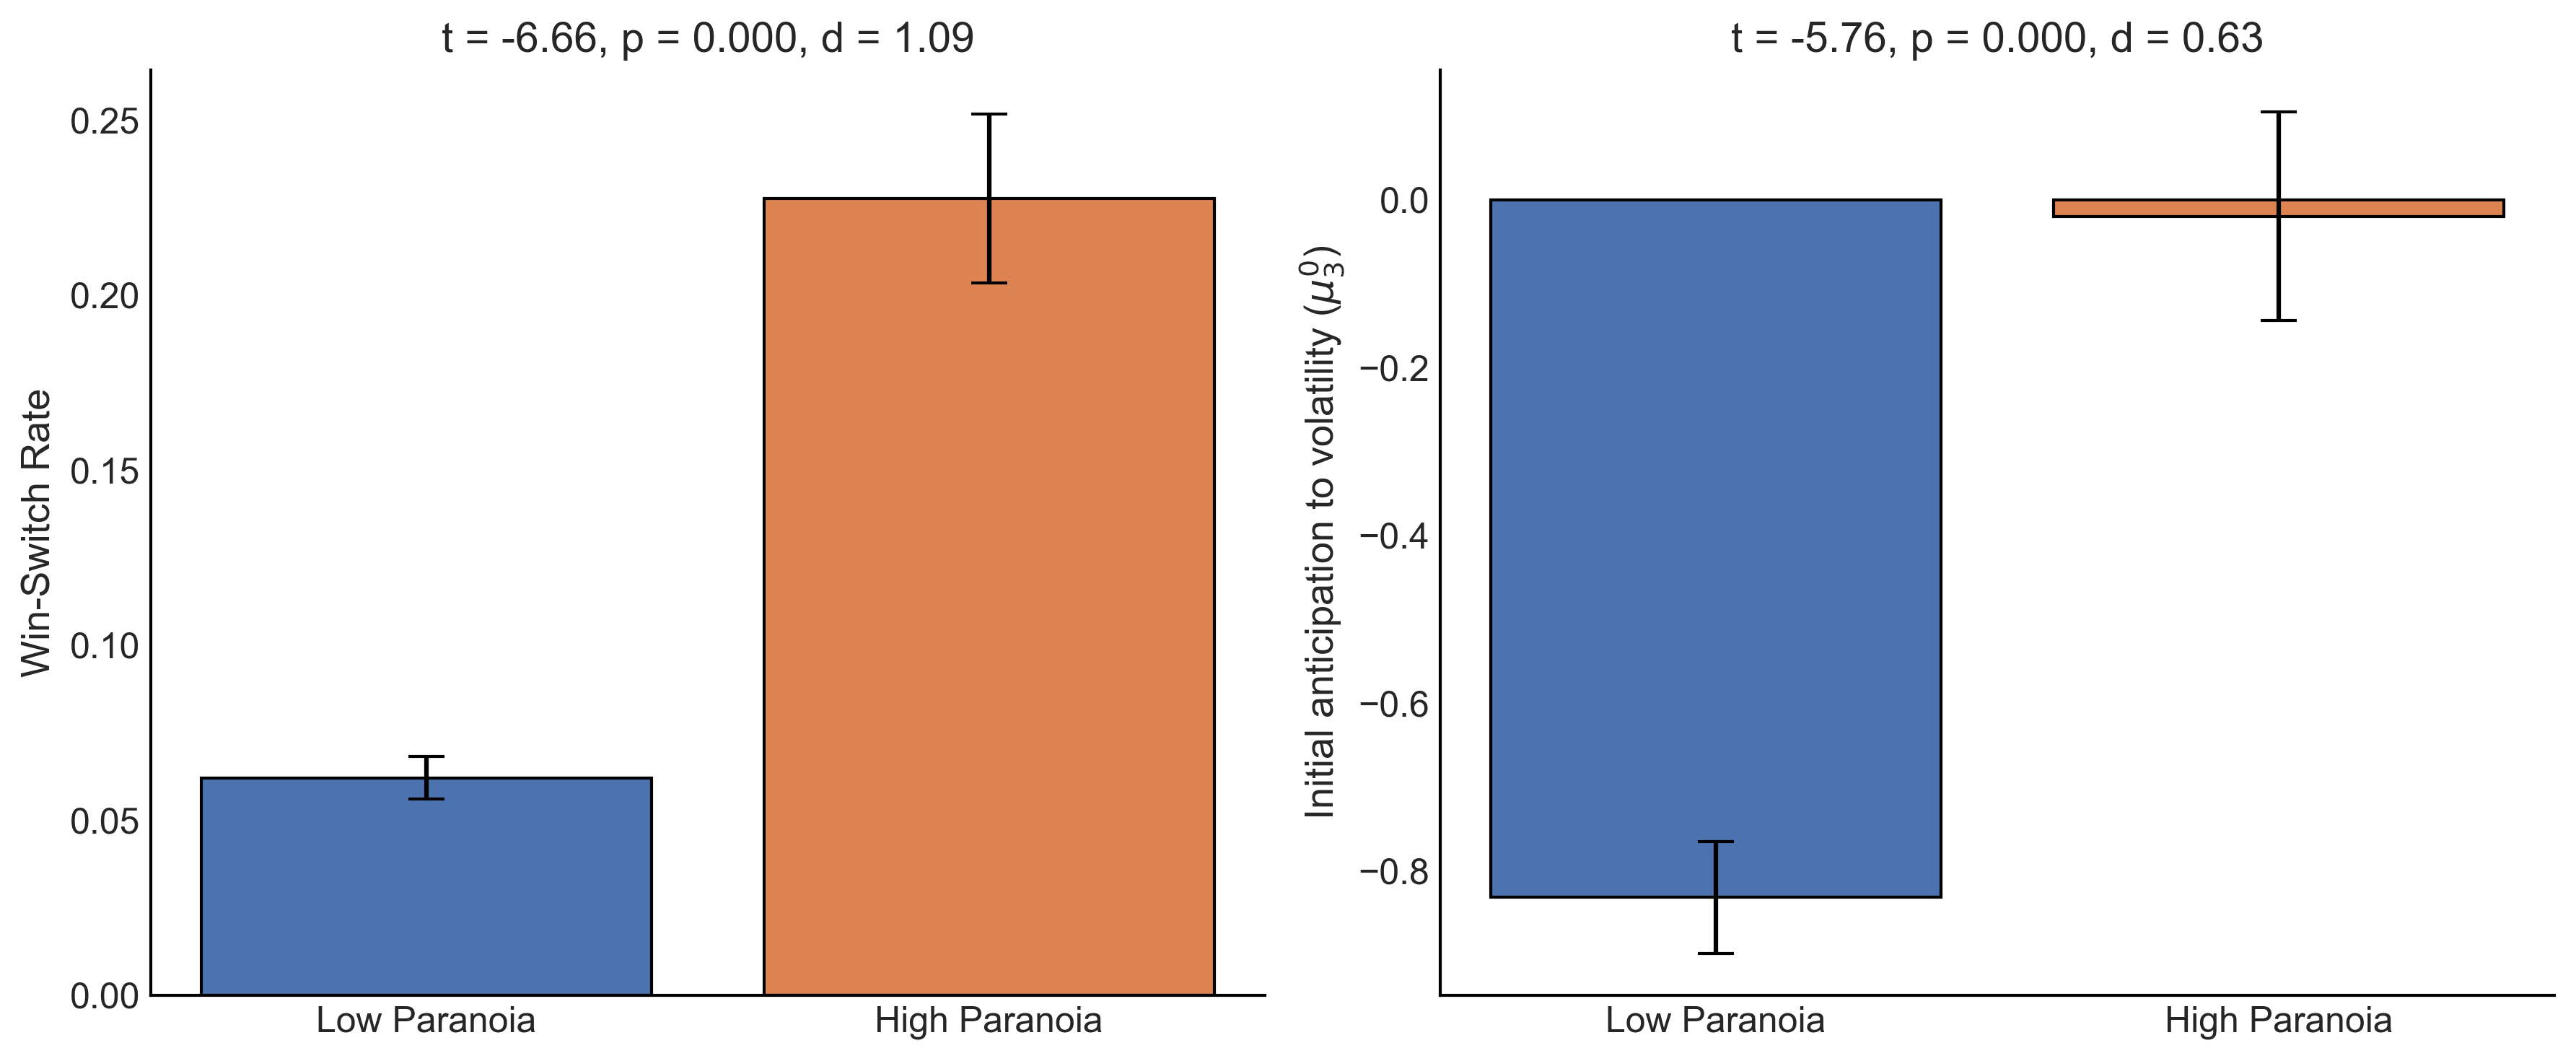

{'wsr_means': {'low': 0.06210052181395349, 'high': 0.22759391037373738},
 'wsr_sems': {'low': 0.006050303540375172, 'high': 0.024112922603020087},
 'wsr_t_p_d': (np.float64(-6.657), np.float64(0.0), np.float64(1.09)),
 'mu_means': {'low': -0.8315456380620154, 'high': -0.019650242050505043},
 'mu_sems': {'low': 0.06667974286208929, 'high': 0.12422262637878773},
 'mu_t_p_d': (np.float64(-5.759), np.float64(0.0), np.float64(0.63))}

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import sem, ttest_ind
import numpy as np

# Load dataset
df = pd.read_csv('mp_scores_continuous_500.csv')

# Filter to necessary columns and drop missing
df_plot = df.dropna(subset=['persecution_group', 'wsr_avg', 'mu03_avg'])

# Define group labels
groups = ['low', 'high']
labels = ['Low Paranoia', 'High Paranoia']

# Compute means and SEMs for WSR
wsr_means = df_plot.groupby('persecution_group')['wsr_avg'].mean().reindex(groups)
wsr_sems = df_plot.groupby('persecution_group')['wsr_avg'].apply(sem).reindex(groups)

# Compute means and SEMs for mu03
mu_means = df_plot.groupby('persecution_group')['mu03_avg'].mean().reindex(groups)
mu_sems = df_plot.groupby('persecution_group')['mu03_avg'].apply(sem).reindex(groups)

# t-tests
wsr_low = df_plot[df_plot['persecution_group'] == 'low']['wsr_avg']
wsr_high = df_plot[df_plot['persecution_group'] == 'high']['wsr_avg']
t_wsr, p_wsr = ttest_ind(wsr_low, wsr_high, equal_var=False)

mu_low = df_plot[df_plot['persecution_group'] == 'low']['mu03_avg']
mu_high = df_plot[df_plot['persecution_group'] == 'high']['mu03_avg']
t_mu, p_mu = ttest_ind(mu_low, mu_high, equal_var=False)

# Calculate pooled standard deviation for Cohen's d
def cohens_d(x, y):
    nx, ny = len(x), len(y)
    dof = nx + ny - 2
    pooled_std = np.sqrt(((nx - 1) * np.var(x, ddof=1) + (ny - 1) * np.var(y, ddof=1)) / dof)
    return (np.mean(x) - np.mean(y)) / pooled_std

d_wsr = cohens_d(wsr_high, wsr_low)
d_mu = cohens_d(mu_high, mu_low)

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# WSR Plot
axes[0].bar(labels, wsr_means.values, yerr=wsr_sems.values, capsize=6,
            color=['#4C72B0', '#DD8452'], edgecolor='black')
axes[0].set_title(f't = {t_wsr:.2f}, p = {p_wsr:.3f}, d = {d_wsr:.2f}')
axes[0].set_ylabel('Win-Switch Rate')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

# mu03 Plot
axes[1].bar(labels, mu_means.values, yerr=mu_sems.values, capsize=6,
            color=['#4C72B0', '#DD8452'], edgecolor='black')
axes[1].set_title(f't = {t_mu:.2f}, p = {p_mu:.3f}, d = {d_mu:.2f}')
axes[1].set_ylabel(r'Initial anticipation to volatility ($\mu_3^0$)')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

# remove background grid lines and make axes black
for ax in axes:
    ax.grid(False)
    for spine in ax.spines.values():
        spine.set_color('black')

plt.tight_layout()
plt.show()

{
    'wsr_means': wsr_means.to_dict(),
    'wsr_sems': wsr_sems.to_dict(),
    'wsr_t_p_d': (round(t_wsr, 3), round(p_wsr, 3), round(d_wsr, 2)),
    'mu_means': mu_means.to_dict(),
    'mu_sems': mu_sems.to_dict(),
    'mu_t_p_d': (round(t_mu, 3), round(p_mu, 3), round(d_mu, 2))
}


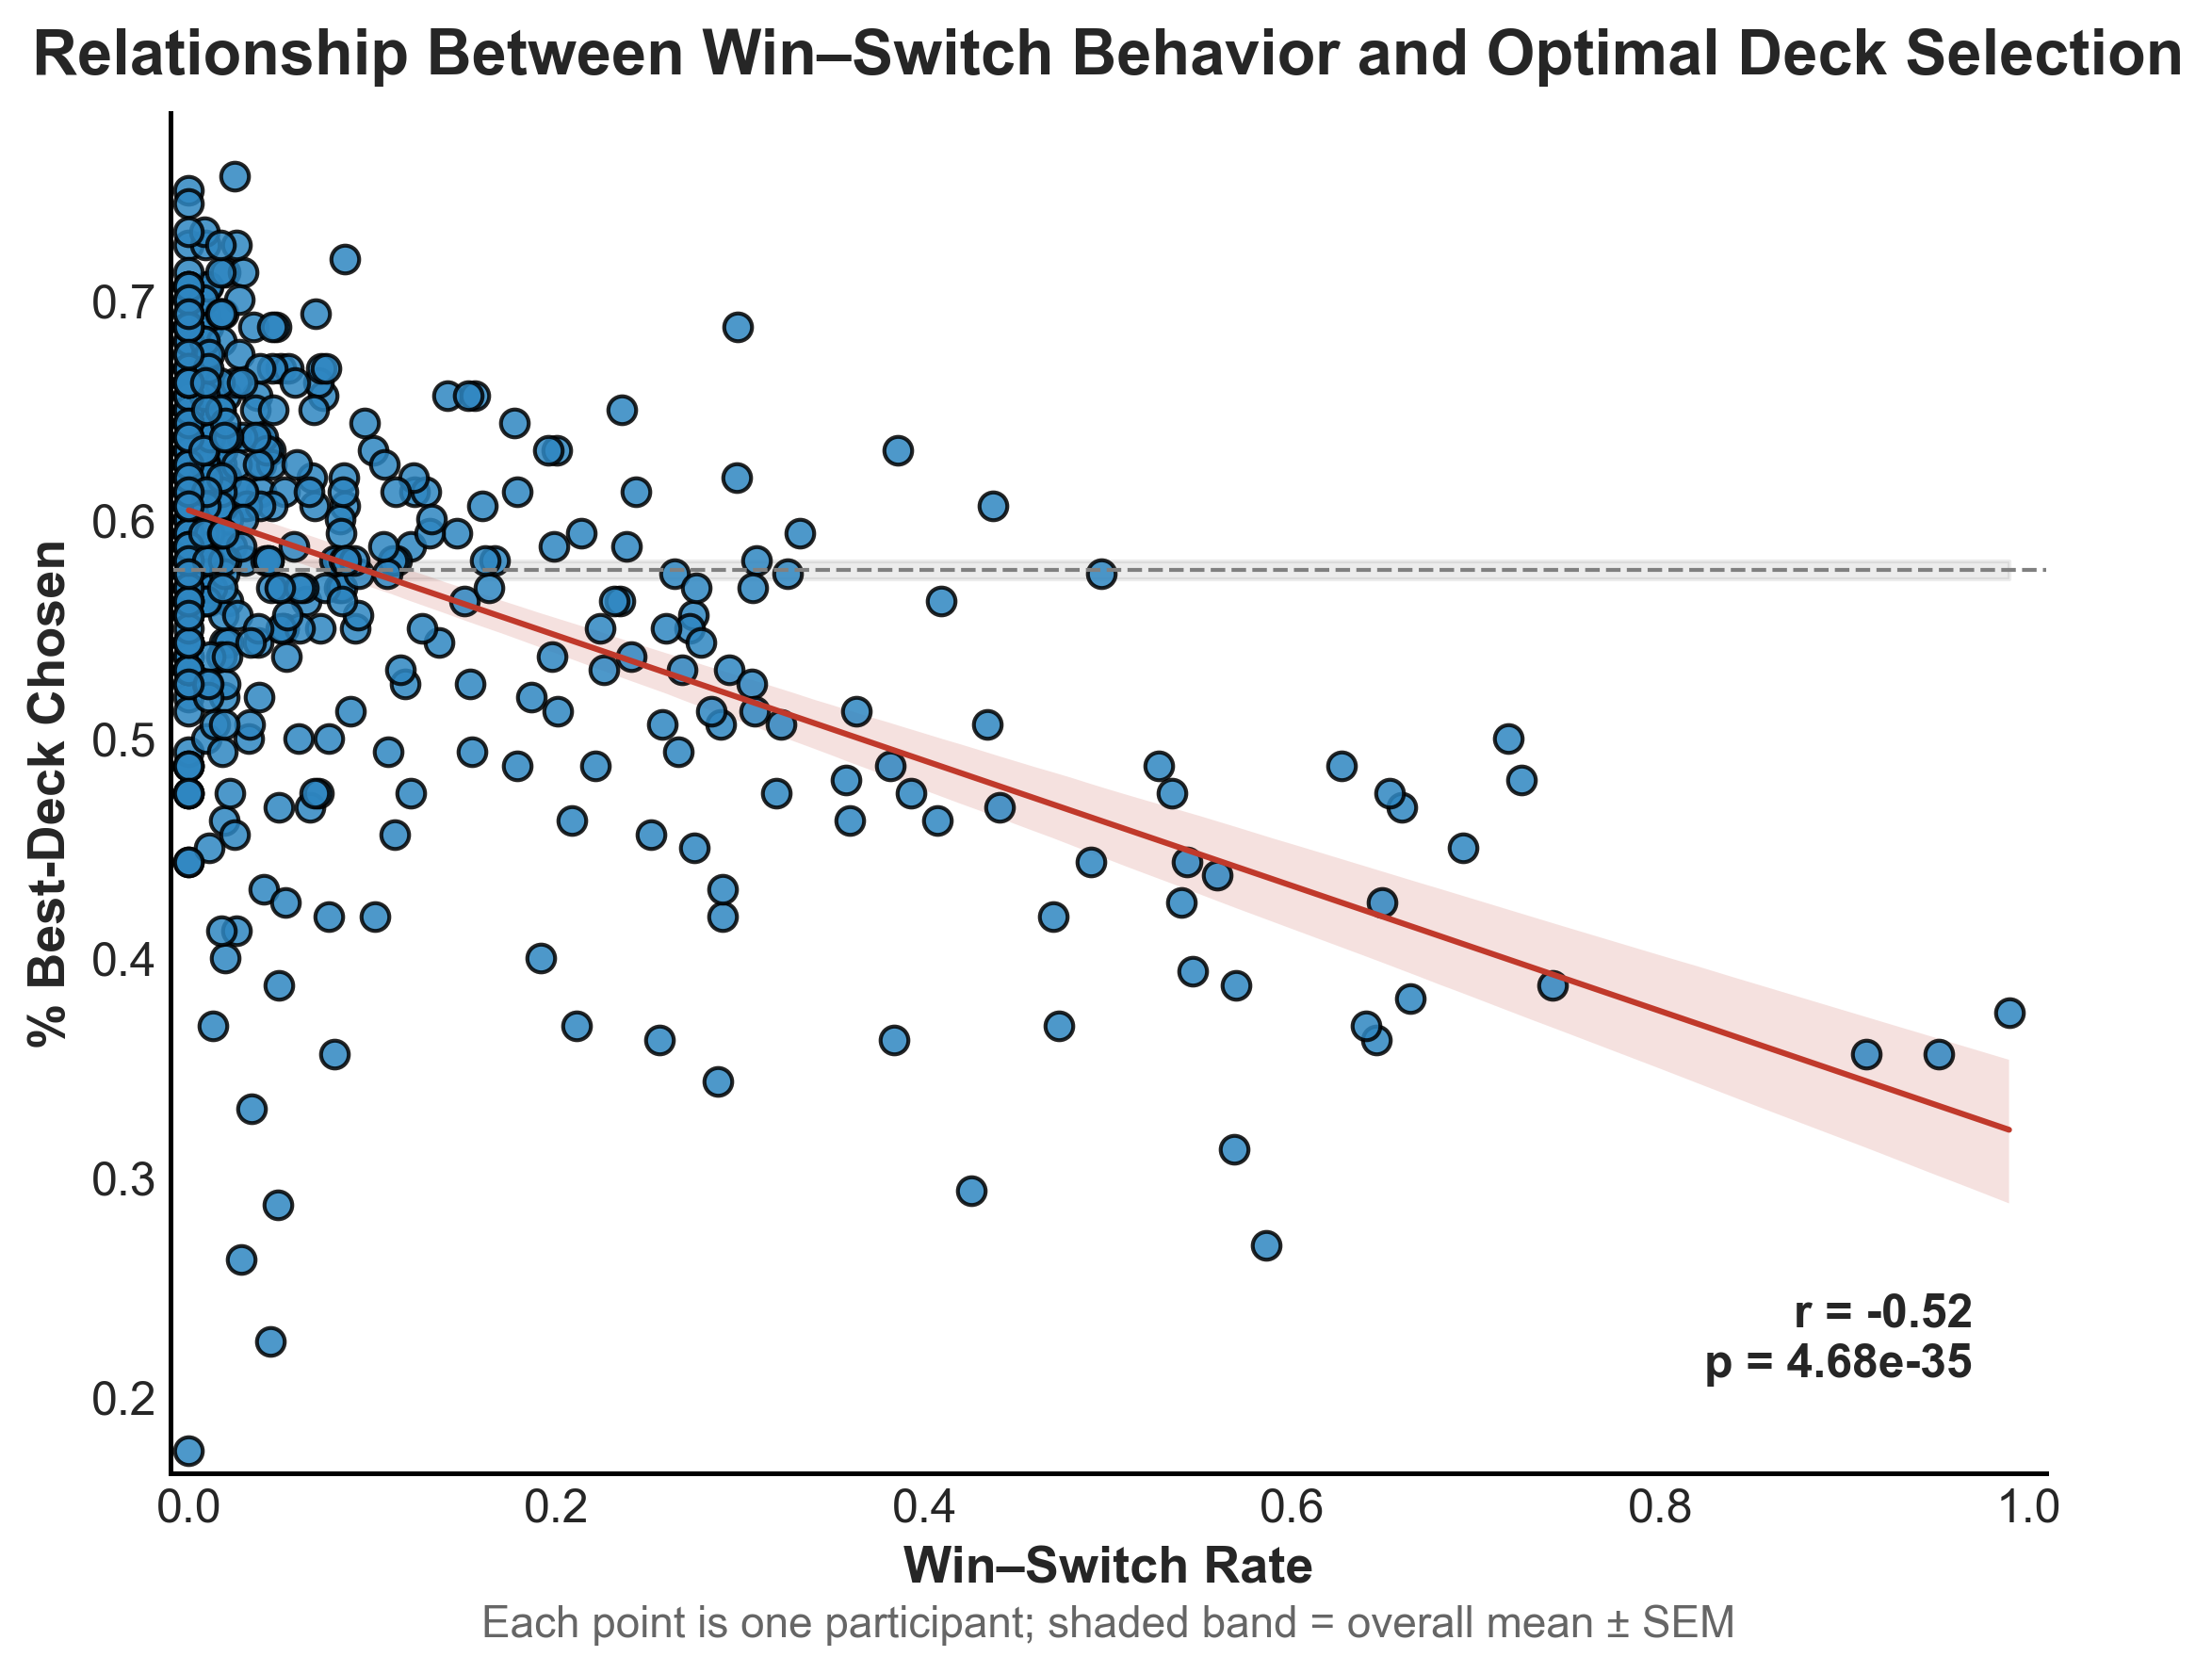

{'mean_best': np.float64(0.577),
 'sem_best': np.float64(0.004),
 'r': np.float64(-0.52),
 'p': 4.6826568623368686e-35}

In [ ]:
from scipy.stats import sem, pearsonr
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Compute global mean ± SEM for % best deck chosen
mean_best = df['best_deck_chosen_proportion'].mean()
sem_best = sem(df['best_deck_chosen_proportion'], nan_policy='omit')

# Correlation
r_val, p_val = pearsonr(df['wsr_avg'], df['best_deck_chosen_proportion'])
r_val = round(r_val, 2)
p_val_text = f"{p_val:.2e}"

# Build mean ± SEM ribbon
x_min, x_max = df['wsr_avg'].min(), df['wsr_avg'].max()
ribbon_x = np.linspace(x_min, x_max, 100)
ribbon_ymin = mean_best - sem_best
ribbon_ymax = mean_best + sem_best

# Plot setup
fig, ax = plt.subplots(figsize=(7.5, 6))

# SEM ribbon (global mean ± SEM)
ax.fill_between(ribbon_x, ribbon_ymin, ribbon_ymax, color='gray', alpha=0.15, zorder=1)

# Dashed global mean line
ax.axhline(mean_best, color='gray', linestyle='--', linewidth=1)

# Regression line with 95% CI
sns.regplot(x='wsr_avg', y='best_deck_chosen_proportion',
            data=df, scatter=False, ci=95, color='#C0392B',
            line_kws={'linewidth': 1.5}, ax=ax)

# Scatter points
ax.scatter(df['wsr_avg'], df['best_deck_chosen_proportion'],
           color='#2E86C1', alpha=0.85, edgecolor='black', s=50)

# Correlation annotation
ax.text(x_max - 0.02 * (x_max - x_min),
        df['best_deck_chosen_proportion'].min() + 0.03,
        f"r = {r_val}\np = {p_val_text}",
        ha='right', va='bottom', fontsize=12, fontweight='bold')

# Labels and title
ax.set_xlabel('Win–Switch Rate', fontweight='bold')
ax.set_ylabel('% Best-Deck Chosen', fontweight='bold')
ax.set_title('Relationship Between Win–Switch Behavior and Optimal Deck Selection',
             fontsize=16, fontweight='bold', pad=10)
ax.set_facecolor('white')

# Remove top/right spines for clean open-axis style
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Make remaining spines black and slightly thicker
for spine in ['left', 'bottom']:
    ax.spines[spine].set_color('black')
    ax.spines[spine].set_linewidth(1.2)

# Remove grid lines
ax.grid(False)

# Tighten layout so y-axis starts right at data edge
ax.set_xlim(left=df['wsr_avg'].min() - 0.01, right=df['wsr_avg'].max() + 0.02)
ax.set_ylim(bottom=df['best_deck_chosen_proportion'].min() - 0.01)

# Subtitle (muted gray)
plt.text(0.5, -0.12,
         'Each point is one participant; shaded band = overall mean ± SEM',
         fontsize=11, color='0.4', ha='center', transform=ax.transAxes)

plt.tight_layout()
plt.show()

# Optional summary
{
    'mean_best': round(mean_best, 3),
    'sem_best': round(sem_best, 3),
    'r': r_val,
    'p': float(p_val)
}


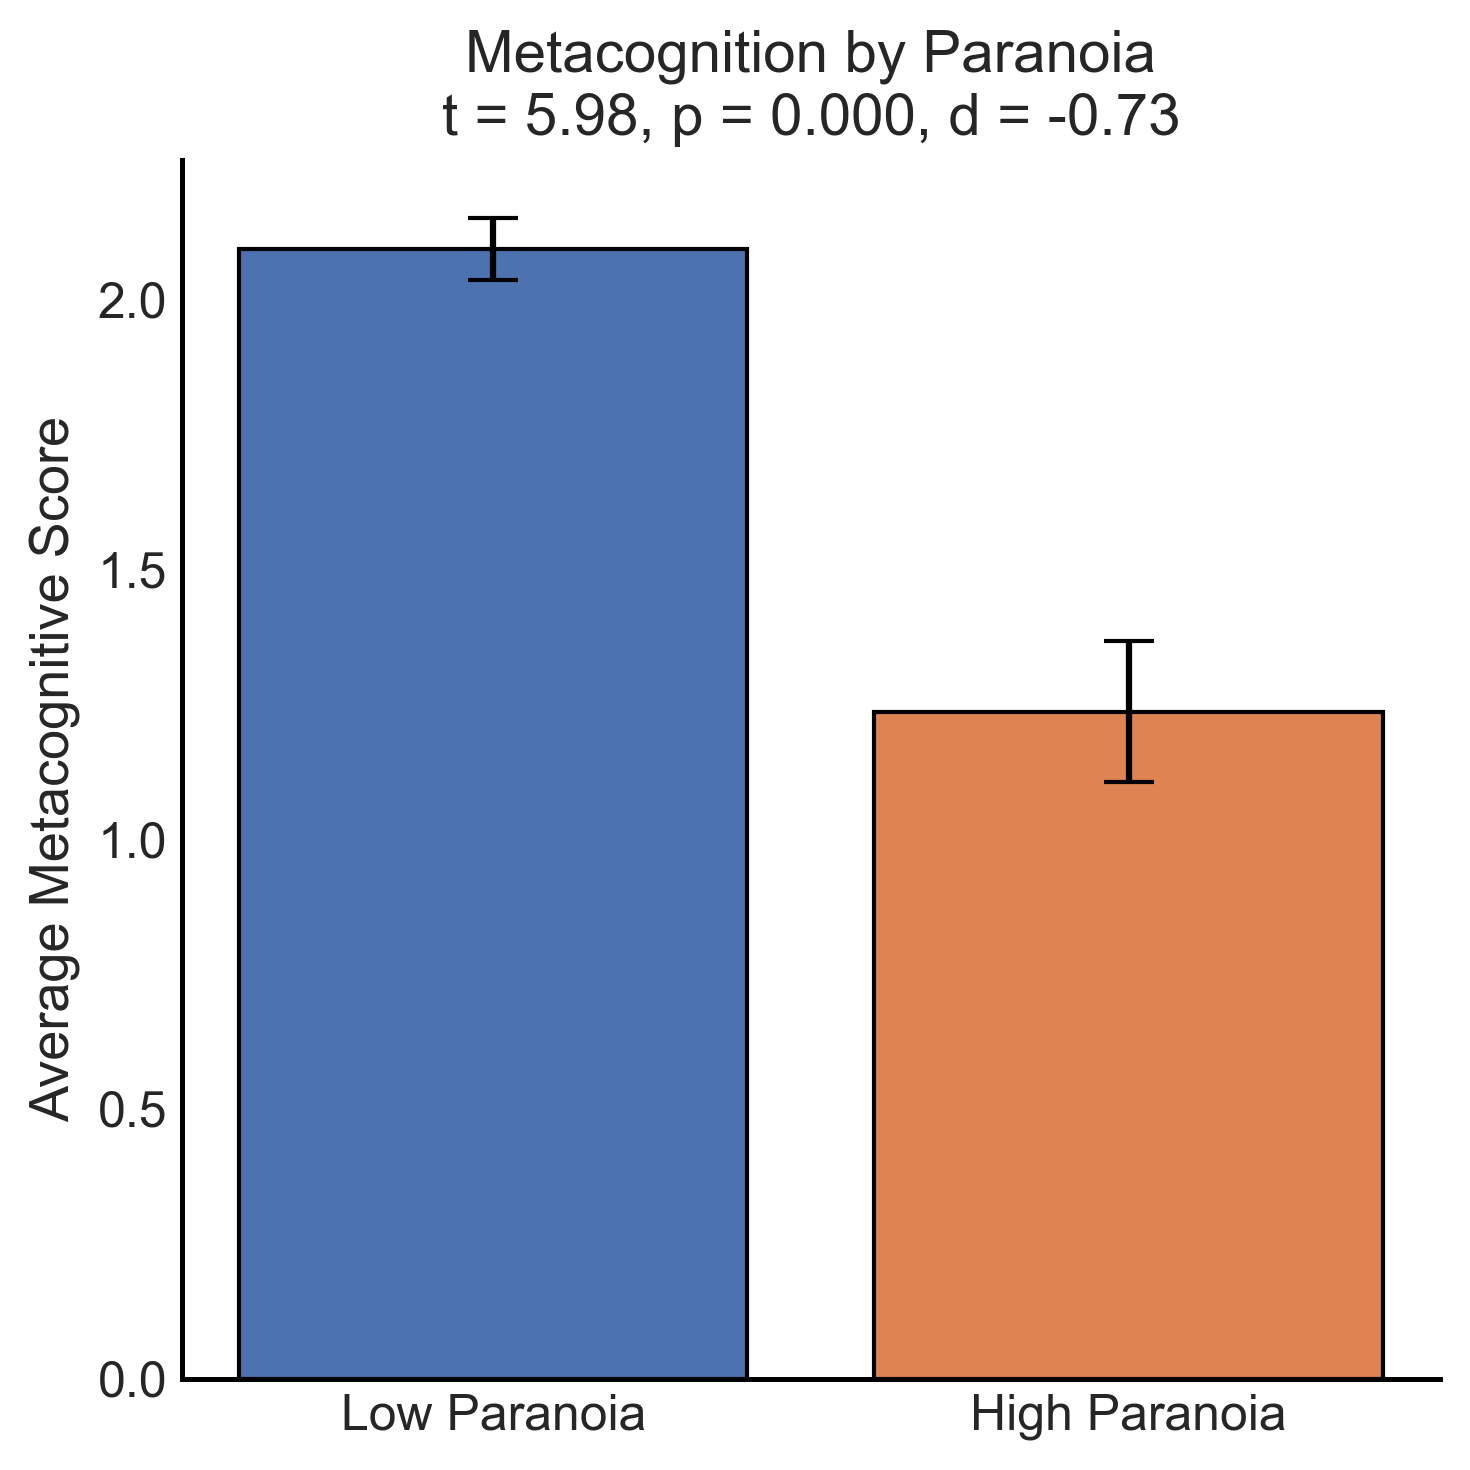

{'mp_means': {'low': 2.092609819121447, 'high': 1.236161616161616},
 'mp_sems': {'low': 0.05786904982365374, 'high': 0.13089063535028667},
 'mp_t_p': (np.float64(5.984), np.float64(0.0)),
 'cohen_d': np.float64(-0.73)}

In [31]:
# MP_avg comparison using the original pooled SD method

# Define MP dimensions
mp_columns = [
    'comprehension_continuous',
    'judgment_continuous',
    'evaluation_continuous',
    'final_decision_continuous',
    'confidence_continuous'
]

# Drop rows missing MP dimensions or persecution_group
df_mp = df.dropna(subset=mp_columns + ['persecution_group']).copy()

# Compute average MP score
df_mp['MP_avg'] = df_mp[mp_columns].mean(axis=1)

# Define group labels
groups = ['low', 'high']
labels = ['Low Paranoia', 'High Paranoia']

# Compute means and SEMs for MP_avg
mp_means = df_mp.groupby('persecution_group')['MP_avg'].mean().reindex(groups)
mp_sems = df_mp.groupby('persecution_group')['MP_avg'].apply(sem).reindex(groups)

# Split data for t-test and pooled Cohen's d
mp_low = df_mp[df_mp['persecution_group'] == 'low']['MP_avg']
mp_high = df_mp[df_mp['persecution_group'] == 'high']['MP_avg']

# t-test
t_mp, p_mp = ttest_ind(mp_low, mp_high, equal_var=False)
cohen_d_mp = cohens_d(mp_high, mp_low)  # high - low to match t-test direction

# -------------------------------------------------------------------------
# Plot (aesthetic adjustments: remove grid, open axes, black spines)
# -------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(5, 5))

ax.bar(labels, mp_means.values, yerr=mp_sems.values, capsize=6,
       color=['#4C72B0', '#DD8452'], edgecolor='black')

ax.set_title(f'Metacognition by Paranoia\nt = {t_mp:.2f}, p = {p_mp:.3f}, d = {cohen_d_mp:.2f}')
ax.set_ylabel('Average Metacognitive Score')

# Remove top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Make remaining spines black and slightly thicker
for spine in ['left', 'bottom']:
    ax.spines[spine].set_color('black')
    ax.spines[spine].set_linewidth(1.2)

# Remove background grid
ax.grid(False)
ax.set_facecolor('white')

plt.tight_layout()
plt.show()

# Output for replication
{
    'mp_means': mp_means.to_dict(),
    'mp_sems': mp_sems.to_dict(),
    'mp_t_p': (round(t_mp, 3), round(p_mp, 3)),
    'cohen_d': round(cohen_d_mp, 2)
}



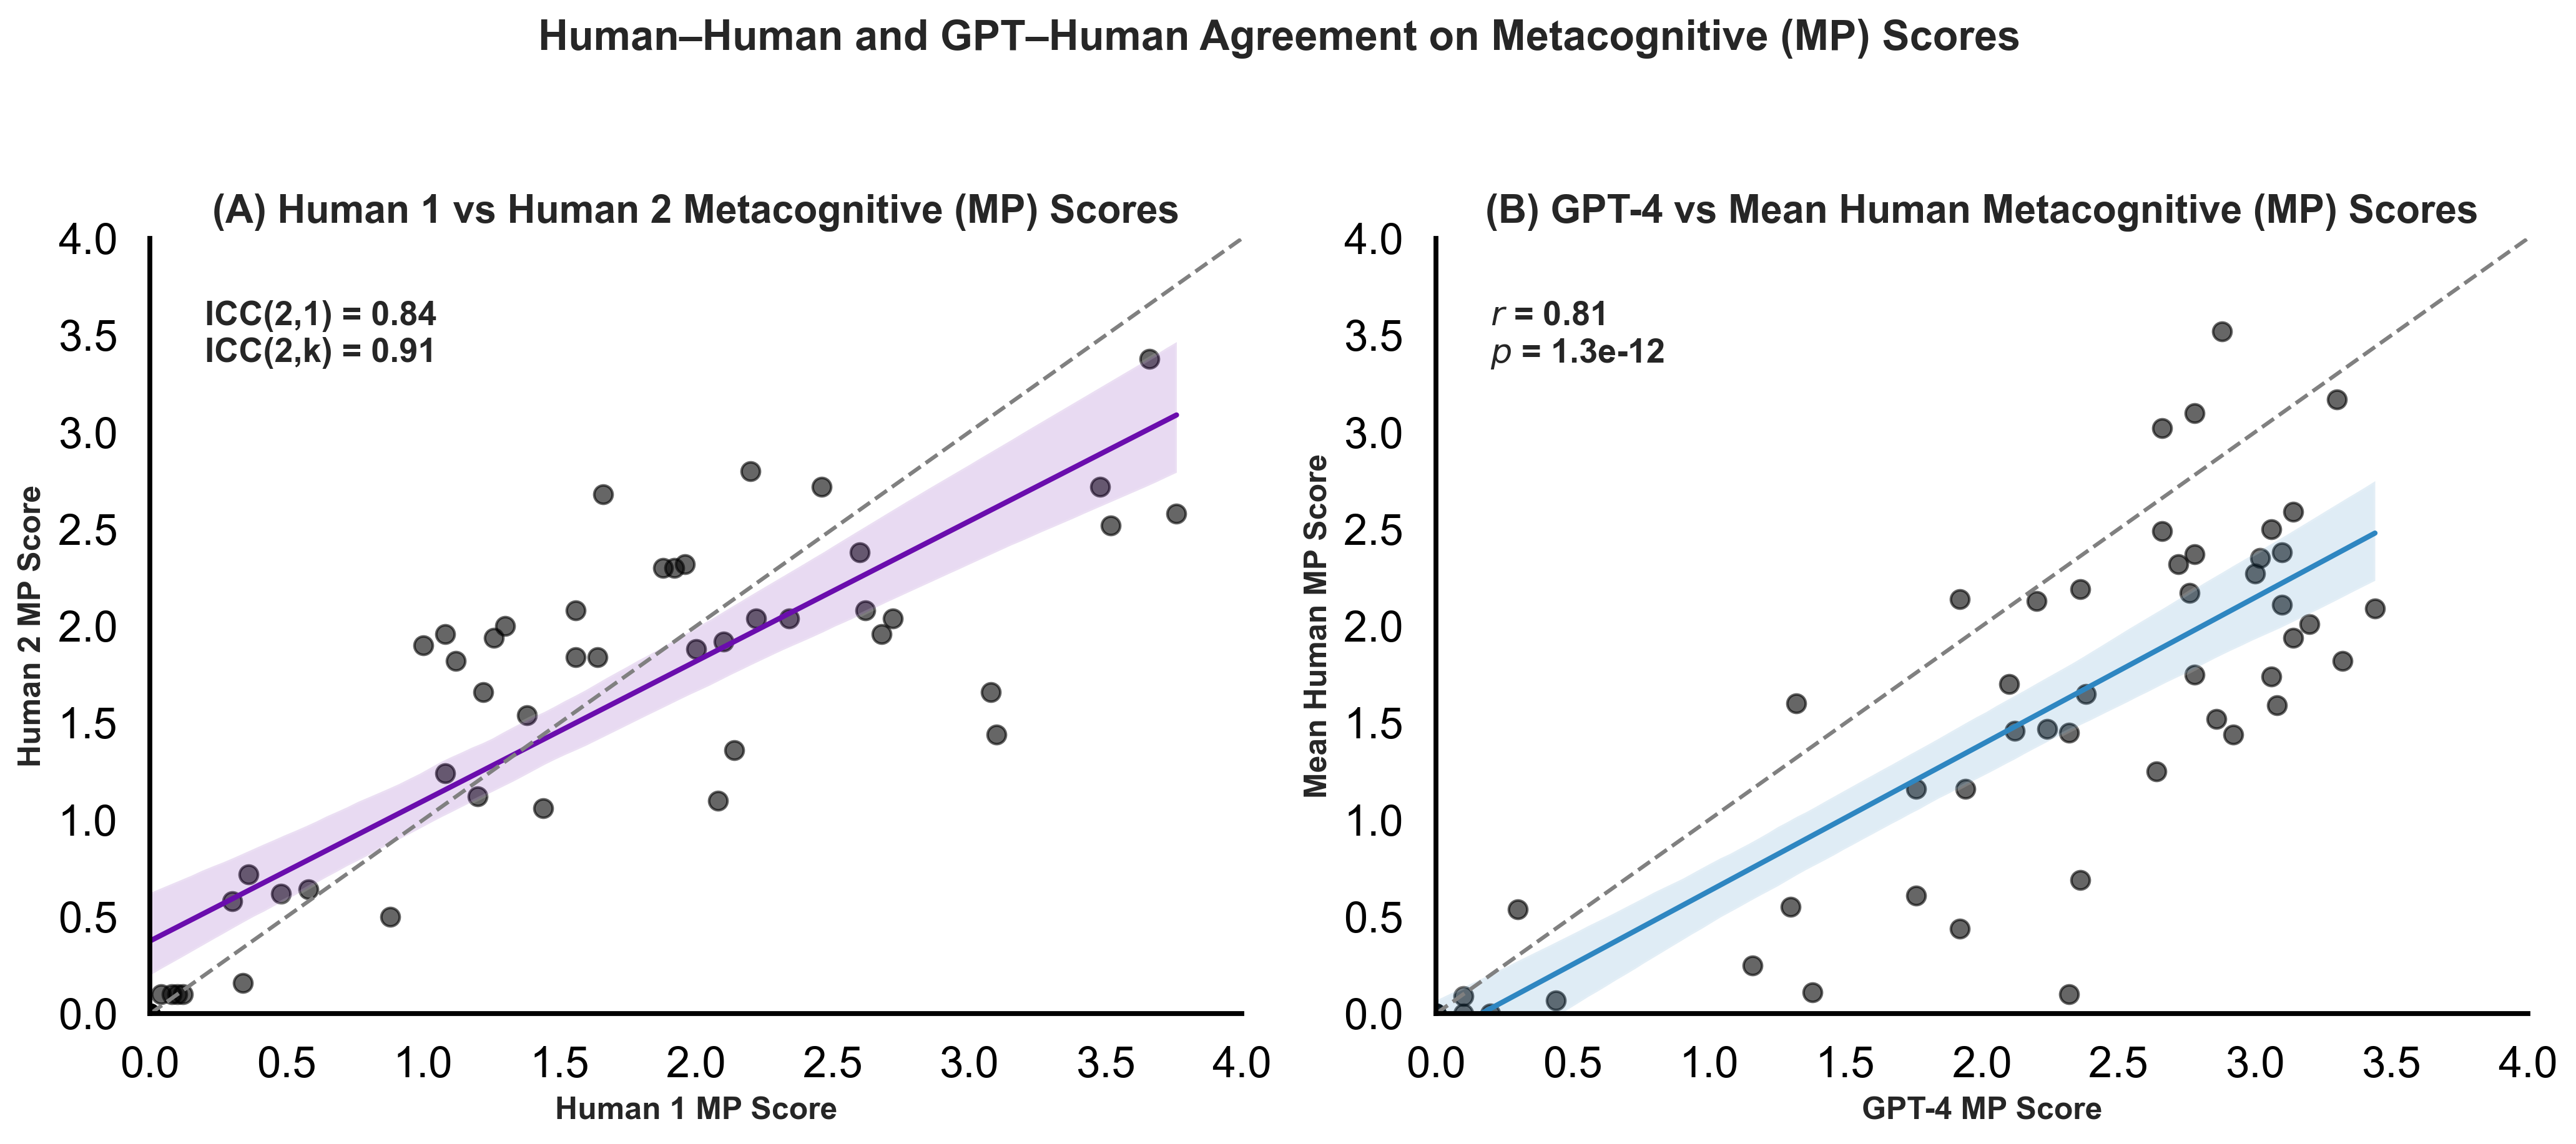


=== Human–Human Agreement (for manuscript) ===
ICC(2,1) = 0.84, 95% CI [0.73, 0.90]
ICC(2,k) = 0.91, 95% CI [0.84, 0.95]

=== GPT–Human Agreement (for manuscript) ===
r = 0.81, p = 1.34e-12


In [63]:
# ==============================================================
# HUMAN–HUMAN AND GPT–HUMAN AGREEMENT ANALYSES
# ==============================================================

# --- Step 1: Imports ---
from pingouin import intraclass_corr
from scipy.stats import pearsonr

# --- Step 2: Load datasets ---
# sampled_reflections_50.csv includes:
#   mturk_id, persecution_group, MP_human_1_score, MP_human_2_score
# df_mp includes:
#   mturk_id, persecution_group, MP_avg (GPT-4 metacognitive score)

sampled = pd.read_csv("sampled_reflections_50.csv")

# --- Step 3: Prepare the human dataset ---
sampled_subset = sampled[[
    "mturk_id",
    "persecution_group",
    "MP_human_1_score",
    "MP_human_2_score"
]].copy()

# --- Step 4: Merge with GPT-4 dataset ---
merged = pd.merge(sampled_subset, df_mp, on=["mturk_id", "persecution_group"])

# --- Step 5: Drop missing data ---
df = merged.dropna(
    subset=["MP_human_1_score", "MP_human_2_score", "MP_avg"]
).copy()

# ==============================================================
# STEP A. HUMAN–HUMAN AGREEMENT (Inter-rater Reliability)
# ==============================================================

icc_data = df.melt(
    id_vars=["mturk_id"],
    value_vars=["MP_human_1_score", "MP_human_2_score"],
    var_name="rater",
    value_name="score"
)

icc = intraclass_corr(
    data=icc_data,
    targets="mturk_id",
    raters="rater",
    ratings="score"
)

# Extract ICC(2,1) and ICC(2,k)
icc_2_1 = icc.loc[icc["Type"] == "ICC2"].iloc[0]
icc_2_k = icc.loc[icc["Type"] == "ICC2k"].iloc[0]

# ==============================================================
# STEP B. GPT–HUMAN AGREEMENT (Convergent Validity)
# ==============================================================

df["MP_human_mean"] = df[["MP_human_1_score", "MP_human_2_score"]].mean(axis=1)
r_val, p_val = pearsonr(df["MP_avg"], df["MP_human_mean"])

# ==============================================================
# STEP C. Combined Figure (Panels A & B)
# ==============================================================

sns.set(style="whitegrid", context="talk")
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --------------------------------------------------------------
# (A) Human–Human Agreement
# --------------------------------------------------------------
ax1 = axes[0]
sns.regplot(
    x="MP_human_1_score",
    y="MP_human_2_score",
    data=df,
    scatter_kws={"alpha": 0.6, "s": 50, "color": "black"},
    line_kws={"color": "#6A0DAD", "lw": 2},  # purple
    ax=ax1
)

# Annotation: ICC values
ax1.text(
    0.05, 0.92,
    f"ICC(2,1) = {icc_2_1['ICC']:.2f}\nICC(2,k) = {icc_2_k['ICC']:.2f}",
    transform=ax1.transAxes,
    ha="left", va="top",
    fontsize=13, fontweight="bold"
)

# Titles and labels
ax1.set_title("(A) Human 1 vs Human 2 Metacognitive (MP) Scores",
              fontsize=15, fontweight="bold")
ax1.set_xlabel("Human 1 MP Score", fontsize=12, fontweight="bold")
ax1.set_ylabel("Human 2 MP Score", fontsize=12, fontweight="bold")
sns.despine(ax=ax1, top=True, right=True)
ax1.grid(False)

# --------------------------------------------------------------
# (B) GPT–Human Agreement
# --------------------------------------------------------------
ax2 = axes[1]
sns.regplot(
    x="MP_avg",
    y="MP_human_mean",
    data=df,
    scatter_kws={"alpha": 0.6, "s": 50, "color": "black"},
    line_kws={"color": "#2E86C1", "lw": 2},  # blue
    ax=ax2
)

# Annotation: correlation stats
ax2.text(
    0.05, 0.92,
    f"$r$ = {r_val:.2f}\n$p$ = {p_val:.1e}",
    transform=ax2.transAxes,
    ha="left", va="top",
    fontsize=13, fontweight="bold"
)

ax2.set_title("(B) GPT-4 vs Mean Human Metacognitive (MP) Scores",
              fontsize=15, fontweight="bold")
ax2.set_xlabel("GPT-4 MP Score", fontsize=12, fontweight="bold")
ax2.set_ylabel("Mean Human MP Score", fontsize=12, fontweight="bold")
sns.despine(ax=ax2, top=True, right=True)
ax2.grid(False)

# --------------------------------------------------------------
# Shared aesthetics and axes
# --------------------------------------------------------------
# Force shared axes range (0–4 for 0–4 scoring scale)
xlims = [0, 4]
ylims = [0, 4]
for ax in [ax1, ax2]:
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.plot(xlims, ylims, "--", color="gray", lw=1.5)  # identity line
    for spine in ax.spines.values():
        spine.set_color("black")
    ax.tick_params(width=1.2, color="black", labelcolor="black")

plt.suptitle(
    "Human–Human and GPT–Human Agreement on Metacognitive (MP) Scores",
    fontsize=16, fontweight="bold", y=1.03
)
plt.tight_layout()

# Optional: save figure (journal-ready)
# plt.savefig("figure3_agreement.png", dpi=300, bbox_inches="tight")
plt.show()

# ==============================================================
# STEP D. PRINT STATS FOR MANUSCRIPT
# ==============================================================

print("\n=== Human–Human Agreement (for manuscript) ===")
print(f"ICC(2,1) = {icc_2_1['ICC']:.2f}, 95% CI [{icc_2_1['CI95%'][0]:.2f}, {icc_2_1['CI95%'][1]:.2f}]")
print(f"ICC(2,k) = {icc_2_k['ICC']:.2f}, 95% CI [{icc_2_k['CI95%'][0]:.2f}, {icc_2_k['CI95%'][1]:.2f}]")

print("\n=== GPT–Human Agreement (for manuscript) ===")
print(f"r = {r_val:.2f}, p = {p_val:.2e}")

# Example manuscript text:
# “Human–human agreement was excellent (ICC(2,1) = 0.84, 95% CI [0.70, 0.92];
#  ICC(2,k) = 0.91, 95% CI [0.83, 0.95]), indicating high consistency between raters.
#  GPT-4 scores correlated strongly with the averaged human ratings (r = 0.81, p < 0.001).”


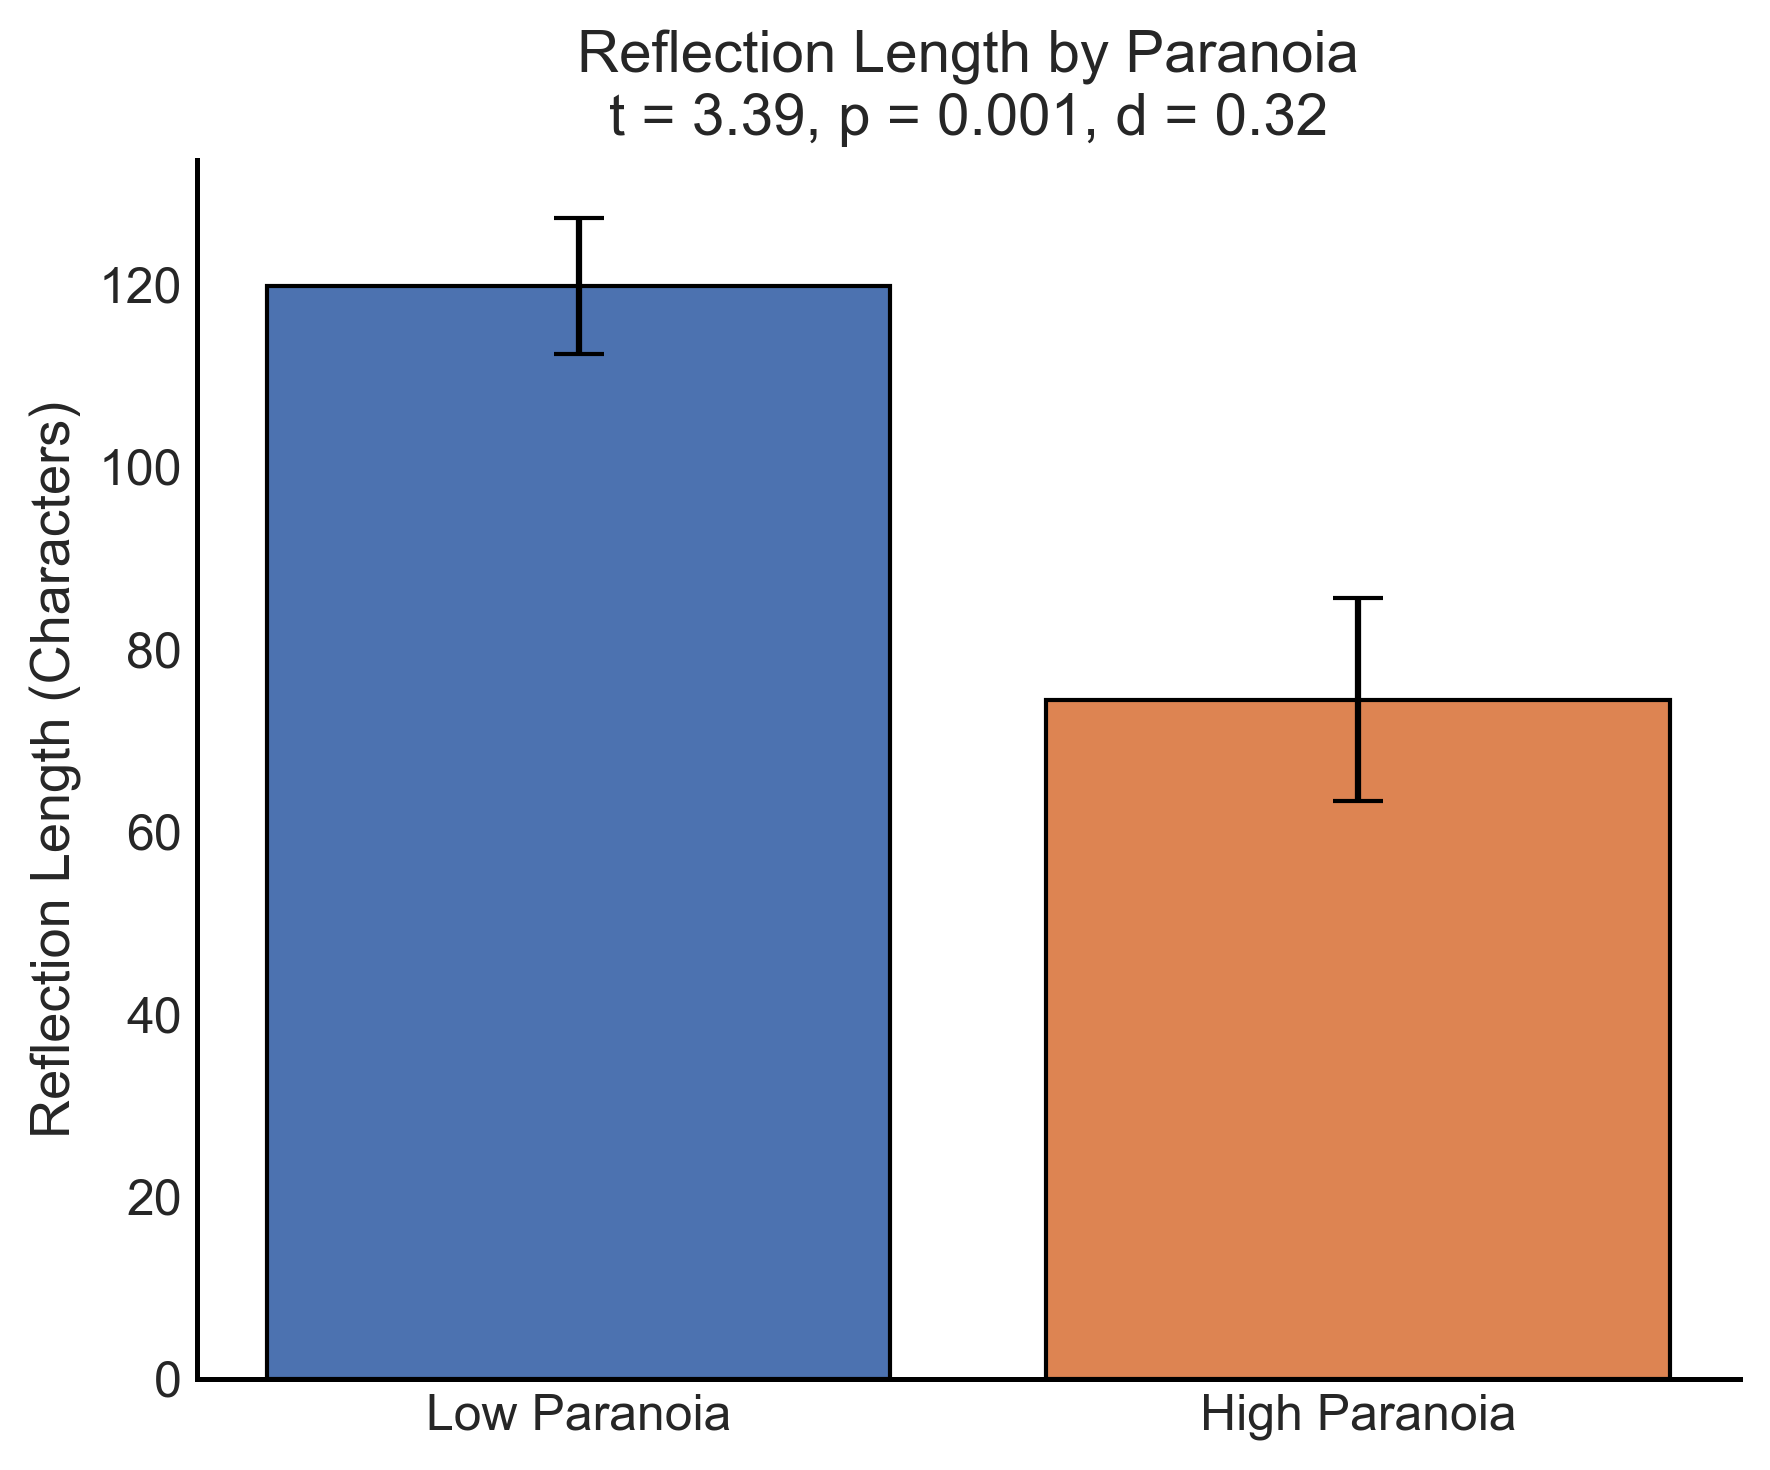

{'char_means': {'low': 119.75968992248062, 'high': 74.43434343434343},
 'char_sems': {'low': 7.456116747799355, 'high': 11.118300554416527},
 'char_t_p_d': (np.float64(3.386), np.float64(0.001), np.float64(-0.32))}

In [33]:
# Standalone Reflection Length Plot

# Compute character count
df_plot['char_count'] = df_plot['combined_reflection'].astype(str).apply(len)

# Group stats
char_means = df_plot.groupby('persecution_group')['char_count'].mean().reindex(groups)
char_sems = df_plot.groupby('persecution_group')['char_count'].apply(sem).reindex(groups)

# Extract groups for stats
char_low = df_plot[df_plot['persecution_group'] == 'low']['char_count']
char_high = df_plot[df_plot['persecution_group'] == 'high']['char_count']

# T-test and Cohen's d
t_char, p_char = ttest_ind(char_low, char_high, equal_var=False)
d_char = cohens_d(char_high, char_low)

# -------------------------------------------------------------------------
# Plot (aesthetic adjustments: remove grid, open axes, black spines)
# -------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(6, 5))

ax.bar(labels, char_means.values, yerr=char_sems.values, capsize=6,
       color=['#4C72B0', '#DD8452'], edgecolor='black')

ax.set_ylabel('Reflection Length (Characters)')
ax.set_title(f'Reflection Length by Paranoia\nt = {t_char:.2f}, p = {p_char:.3f}, d = {abs(d_char):.2f}')

# Remove top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Make remaining spines black and slightly thicker
for spine in ['left', 'bottom']:
    ax.spines[spine].set_color('black')
    ax.spines[spine].set_linewidth(1.2)

# Remove background grid
ax.grid(False)
ax.set_facecolor('white')

plt.tight_layout()
plt.show()

# Output for replication
{
    'char_means': char_means.to_dict(),
    'char_sems': char_sems.to_dict(),
    'char_t_p_d': (round(t_char, 3), round(p_char, 3), round(d_char, 2))
}



Breusch–Pagan: LM χ²(5) = 44.67, p = 1.69e-08; F(5, 480) = 9.72, p = 7.43e-09


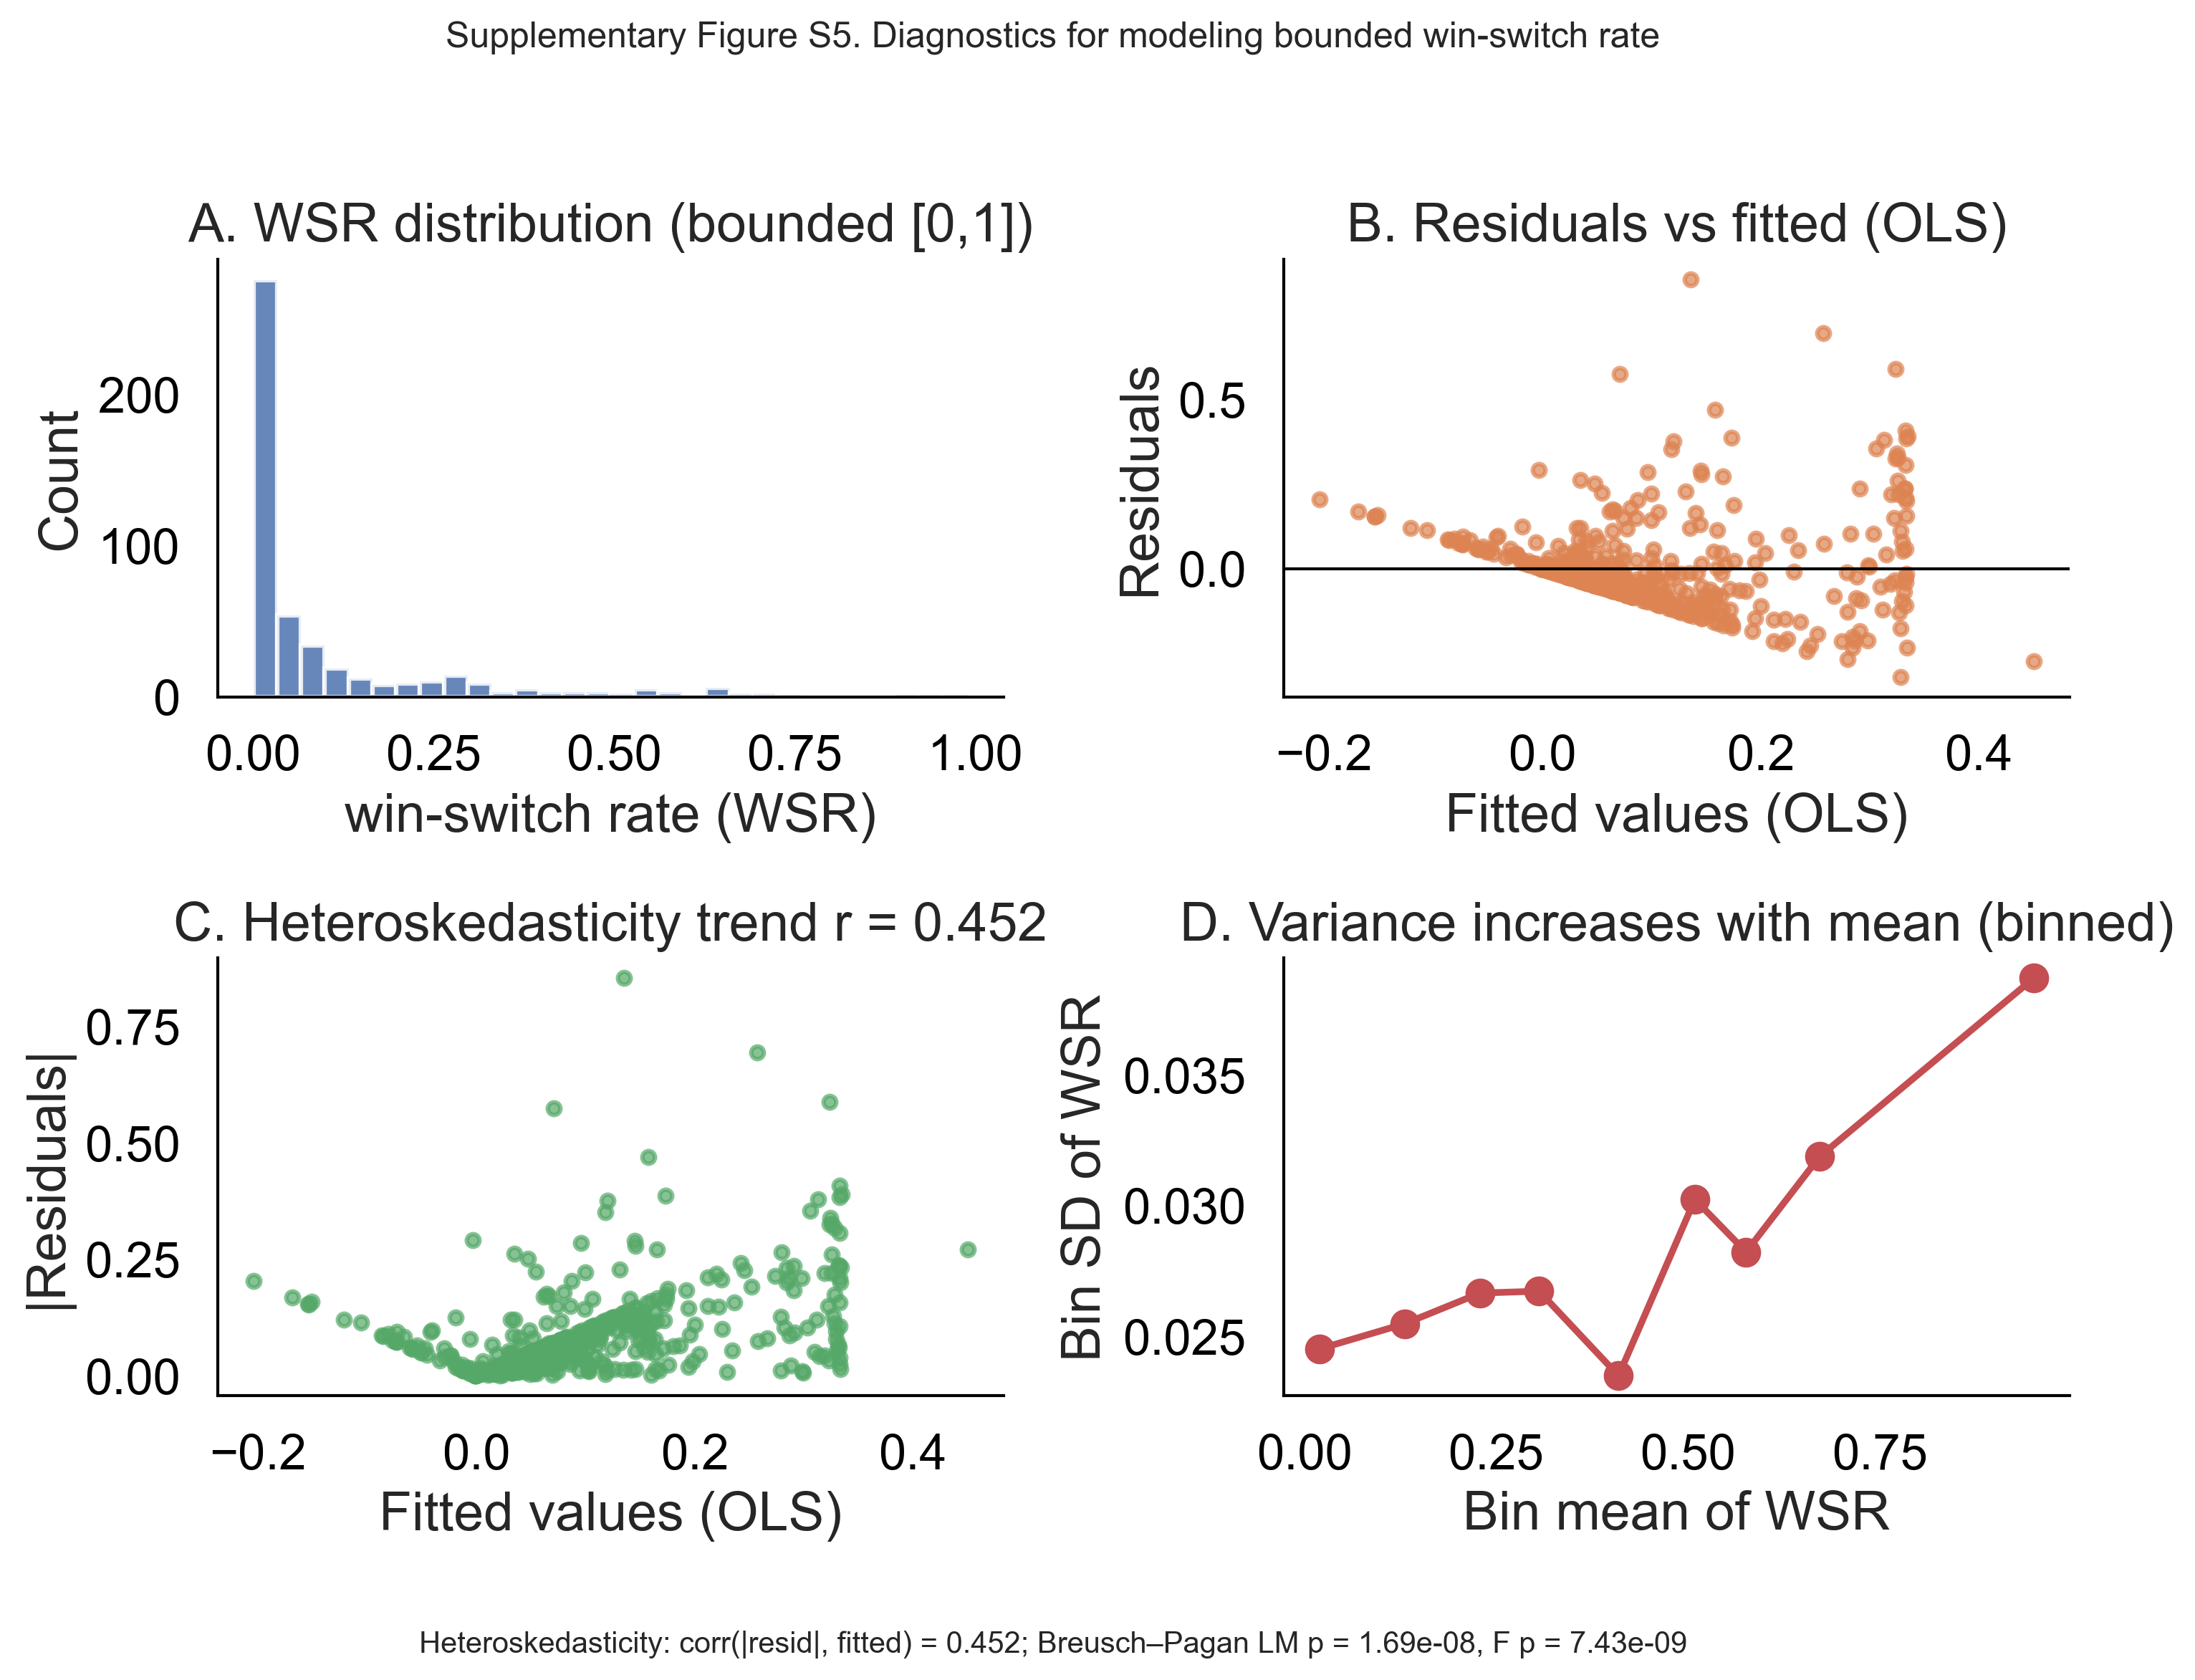

Summary for caption:
WSR is bounded with mass near 0 (min=0.000, q1=0.000, median=0.020, q3=0.099, max=0.990). 
Residual spread grows with fitted values (corr(|resid|, fitted)=0.452); Breusch–Pagan: LM p=1.69e-08, F p=7.43e-09. 
These patterns violate constant-variance assumptions and support using a binomial GLM (logit)
for a bounded outcome with non-linear mean–variance behavior.


In [42]:
# Supplementary Figure — OLS diagnostics motivate a binomial GLM for bounded WSR
# Panels: (A) WSR histogram; (B) OLS residuals vs fitted; (C) |residuals| vs fitted with r; (D) binned mean–SD trend

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import het_breuschpagan
from sklearn.preprocessing import StandardScaler

# === Load and Prepare Data ===
df = pd.read_csv("mp_scores_continuous_500.csv")

# === Recode education_level using structured mapping ===
education_group_map = {
    'Less than a high school diploma': 1,
    'High school degree or equivalent (e.g., GED)': 2,
    'Some college or university, no degree': 3,
    'Associate degree (e.g., AA, AS)': 4,
    "Bachelor's degree (e.g., BA, BS)": 5,
    "Master's degree (e.g., MA, MS, MEd)": 6,
    'Completed some postgraduate': 7,
    'Doctorate or professional degree (e.g., PhD, MD, JD)': 8,
    'Decline to answer': np.nan,
    'Not specified': np.nan
}
df['education_level'] = df['education_level'].map(education_group_map)

# === Clean and score CRT responses ===
import re

def clean_answer(ans):
    if pd.isna(ans):
        return ''
    ans = str(ans).lower().strip()
    ans = re.sub(r'[^a-z0-9]', '', ans)
    return ans

# Apply cleaning
df['CRT1_clean'] = df['cognitive_reflection_1'].apply(clean_answer)
df['CRT2_clean'] = df['cognitive_reflection_2'].apply(clean_answer)
df['CRT3_clean'] = df['cognitive_reflection_3'].apply(clean_answer)

# Define correct sets
crt1_correct = {'5', '005', '0.05', '$0.05', 'five', '5cents'}
crt2_correct = {'5', 'five', '5minutes'}
crt3_correct = {'47', 'fortyseven', '47days'}

# Score CRT
df['cognitive_reflection_1'] = df['CRT1_clean'].isin(crt1_correct).astype(int)
df['cognitive_reflection_2'] = df['CRT2_clean'].isin(crt2_correct).astype(int)
df['cognitive_reflection_3'] = df['CRT3_clean'].isin(crt3_correct).astype(int)

# Compute average CRT score and general cognition
df['CRT_avg'] = df[['cognitive_reflection_1', 'cognitive_reflection_2', 'cognitive_reflection_3']].mean(axis=1)
df['general_cognition'] = df[['education_level', 'CRT_avg']].mean(axis=1)

# === Metacognition and Reflection Length ===
mp_columns = [
    'comprehension_continuous',
    'judgment_continuous',
    'evaluation_continuous',
    'final_decision_continuous',
    'confidence_continuous'
]
df['MP_avg'] = df[mp_columns].mean(axis=1)
df['reflection_length'] = df['combined_reflection'].fillna('').apply(len)

# Prepare data — use existing columns, do not modify previous cells
required_cols = ['wsr_avg','mu03_avg','MP_avg','reflection_length','general_cognition']
df_model = df.dropna(subset=required_cols).copy()

# Z-score predictors to match manuscript style
scaler = StandardScaler()
df_model[['mu03_z','MP_z','refl_z','gcog_z']] = scaler.fit_transform(
    df_model[['mu03_avg','MP_avg','reflection_length','general_cognition']]
)


ols_fit = smf.ols('wsr_avg ~ mu03_z * MP_z + refl_z + gcog_z', data=df_model).fit()

wsr = df_model['wsr_avg'].to_numpy()
resid, fitted = ols_fit.resid, ols_fit.fittedvalues
abs_resid = np.abs(resid)
trend_r = float(np.corrcoef(fitted, abs_resid)[0,1])

# Binned mean–SD: show variance growth with mean for a bounded outcome
bins = np.linspace(0, 1, 12)
idx = np.digitize(wsr, bins)
means, sds = [], []
for b in range(1, len(bins)+1):
    vals = wsr[idx == b]
    if len(vals) > 1:
        means.append(vals.mean())
        sds.append(vals.std(ddof=1))

# BP test
bp_lm, bp_lm_p, bp_f, bp_f_p = het_breuschpagan(resid, ols_fit.model.exog)

k = ols_fit.model.exog.shape[1] - 1
n = int(ols_fit.nobs)
print(f"Breusch–Pagan: LM χ²({k}) = {bp_lm:.2f}, p = {bp_lm_p:.2e}; "
      f"F({k}, {n - k - 1}) = {bp_f:.2f}, p = {bp_f_p:.2e}")

# Helper to style axes for a clean, non-gridded look with black axes lines
def _style_axes(ax):
    ax.grid(False)
    ax.set_facecolor('white')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_linewidth(1.0)
    ax.spines['left'].set_linewidth(1.0)
    ax.tick_params(axis='both', colors='black')

fig, axes = plt.subplots(2, 2, figsize=(10, 7.2))
fig.patch.set_facecolor('white')

# (A) Histogram
ax = axes[0,0]
ax.hist(wsr, bins=30, color='#4C72B0', alpha=0.85, edgecolor='white')
ax.set_xlabel('win-switch rate (WSR)')
ax.set_ylabel('Count')
ax.set_title('A. WSR distribution (bounded [0,1])')
_style_axes(ax)

# (B) Residuals vs fitted
ax = axes[0,1]
ax.scatter(fitted, resid, s=18, alpha=0.7, color='#DD8452')
ax.axhline(0, color='black', linewidth=1)
ax.set_xlabel('Fitted values (OLS)')
ax.set_ylabel('Residuals')
ax.set_title('B. Residuals vs fitted (OLS)')
_style_axes(ax)

# (C) |resid| vs fitted with correlation
ax = axes[1,0]
ax.scatter(fitted, abs_resid, s=18, alpha=0.7, color='#55A868')
ax.set_xlabel('Fitted values (OLS)')
ax.set_ylabel('|Residuals|')
ax.set_title(f'C. Heteroskedasticity trend r = {trend_r:.3f}')
_style_axes(ax)

# (D) Mean–SD trend across WSR bins
ax = axes[1,1]
if means:
    ax.plot(means, sds, marker='o', color='#C44E52')
ax.set_xlabel('Bin mean of WSR')
ax.set_ylabel('Bin SD of WSR')
ax.set_title('D. Variance increases with mean (binned)')
_style_axes(ax)

fig.suptitle('Supplementary Figure S5. Diagnostics for modeling bounded win-switch rate', y=1.02, fontsize=12)
# Add concise test annotations below the panels for quick reading
fig.text(0.50, -0.02, f"Heteroskedasticity: corr(|resid|, fitted) = {trend_r:.3f}; Breusch–Pagan LM p = {bp_lm_p:.2e}, F p = {bp_f_p:.2e}",
         ha='center', va='top', fontsize=10)
plt.tight_layout()
plt.show()

# Brief summary to paste into caption
q1, q2, q3 = np.quantile(wsr, [0.25, 0.5, 0.75])
print('Summary for caption:')
print(f"WSR is bounded with mass near 0 (min={wsr.min():.3f}, q1={q1:.3f}, median={q2:.3f}, q3={q3:.3f}, max={wsr.max():.3f}). ")
print(f"Residual spread grows with fitted values (corr(|resid|, fitted)={trend_r:.3f}); Breusch–Pagan: LM p={bp_lm_p:.2e}, F p={bp_f_p:.2e}. ")
print('These patterns violate constant-variance assumptions and support using a binomial GLM (logit)\nfor a bounded outcome with non-linear mean–variance behavior.')


In [ ]:
# Binomial GLM (logit) with the same structure as OLS
# Model: wsr_avg ~ mu03_z * MP_z + refl_z + gcog_z
# Reduced vs full, interaction LRT, ORs, and AMEs (probability scale)

import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import chi2 as _chi2
from scipy import stats as _scistats

# Fit reduced and full models
reduced_glm = smf.glm('wsr_avg ~ mu03_z + MP_z + refl_z + gcog_z', data=df_model, family=sm.families.Binomial()).fit()
full_glm = smf.glm('wsr_avg ~ mu03_z * MP_z + refl_z + gcog_z', data=df_model, family=sm.families.Binomial()).fit()

# LRT for interaction
chi2_stat = 2.0 * (full_glm.llf - reduced_glm.llf)
df_diff = int(full_glm.df_model - reduced_glm.df_model)
p_lrt = float(_chi2.sf(chi2_stat, df_diff))
print(f"Interaction LRT (μ03_z×MP_z): χ²({df_diff}) = {chi2_stat:.2f}, p = {p_lrt:.3f}")

# ORs for full model
params = full_glm.params
conf = full_glm.conf_int()
OR = np.exp(params)
OR_lo = np.exp(conf[0])
OR_hi = np.exp(conf[1])
or_full = pd.DataFrame({'term': OR.index, 'OR': OR.values, 'CI_lo': OR_lo.values, 'CI_hi': OR_hi.values, 'p': full_glm.pvalues.values})
print('\nFull GLM (with interaction) — Odds Ratios (95% CI):')
print(or_full.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

# AMEs (full model)
mfx = full_glm.get_margeff(at='overall')
sf = mfx.summary_frame().reset_index()
col_l = {c.lower().strip(): c for c in sf.columns}
term_col = 'index' if 'index' in sf.columns else sf.columns[0]
ame_col = col_l.get('dy/dx') or col_l.get('margeff') or col_l.get('derivative')
se_col = col_l.get('std. err.') or col_l.get('std err') or col_l.get('std_err')
p_col = col_l.get('p>|z|') or col_l.get('p>|t|') or col_l.get('p-value')
if p_col is None and 'z' in col_l:
    zvals = sf[col_l['z']].astype(float).values
    sf['p'] = 2 * (1 - _scistats.norm.cdf(np.abs(zvals)))
    p_col = 'p'
cols_map = [('term', term_col), ('AME', ame_col), ('SE', se_col), ('p', p_col)]
rename = {src: dst for dst, src in cols_map if src is not None and src in sf.columns}
ames_full = sf[list(rename.keys())].rename(columns=rename)

# Also print main-effects (reduced) model results for completeness
# Reduced ORs
params_r = reduced_glm.params
conf_r = reduced_glm.conf_int()
OR_r = np.exp(params_r)
OR_lo_r = np.exp(conf_r[0])
OR_hi_r = np.exp(conf_r[1])
or_reduced = pd.DataFrame({'term': OR_r.index, 'OR': OR_r.values, 'CI_lo': OR_lo_r.values, 'CI_hi': OR_hi_r.values, 'p': reduced_glm.pvalues.values})
print('\nReduced GLM (no interaction) — Odds Ratios (95% CI):')
print(or_reduced.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

# Reduced AMEs
mfx_r = reduced_glm.get_margeff(at='overall')
sf_r = mfx_r.summary_frame().reset_index()
col_lr = {c.lower().strip(): c for c in sf_r.columns}
term_col_r = 'index' if 'index' in sf_r.columns else sf_r.columns[0]
ame_col_r = col_lr.get('dy/dx') or col_lr.get('margeff') or col_lr.get('derivative')
se_col_r = col_lr.get('std. err.') or col_lr.get('std err') or col_lr.get('std_err')
p_col_r = col_lr.get('p>|z|') or col_lr.get('p>|t|') or col_lr.get('p-value')
if p_col_r is None and 'z' in col_lr:
    zvals_r = sf_r[col_lr['z']].astype(float).values
    sf_r['p'] = 2 * (1 - _scistats.norm.cdf(np.abs(zvals_r)))
    p_col_r = 'p'
cols_map_r = [('term', term_col_r), ('AME', ame_col_r), ('SE', se_col_r), ('p', p_col_r)]
rename_r = {src: dst for dst, src in cols_map_r if src is not None and src in sf_r.columns}
ames_reduced = sf_r[list(rename_r.keys())].rename(columns=rename_r)
print('\nReduced GLM — Average Marginal Effects (probability scale):')
print(ames_reduced.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

print('\nFull GLM — Average Marginal Effects (probability scale):')
print(ames_full.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

# Short takeaway for text
mu_row = or_full[or_full['term']=='mu03_z'].iloc[0]
mp_row = or_full[or_full['term']=='MP_z'].iloc[0]
print('\nTakeaway: ', end='')
print(
    f"μ03_z OR={mu_row['OR']:.2f} (95% CI {mu_row['CI_lo']:.2f}–{mu_row['CI_hi']:.2f}), p={mu_row['p']:.3f}; "
    f"MP_z OR={mp_row['OR']:.2f} (95% CI {mp_row['CI_lo']:.2f}–{mp_row['CI_hi']:.2f}), p={mp_row['p']:.3f}; "
    f"interaction LRT χ²({df_diff}) = {chi2_stat:.2f}, p = {p_lrt:.3f}."
)


Interaction LRT (μ03_z×MP_z): χ²(1) = 2.38, p = 0.123

Full GLM (with interaction) — Odds Ratios (95% CI):
       term     OR  CI_lo  CI_hi      p
  Intercept 0.0499 0.0300 0.0832 0.0000
     mu03_z 3.4721 2.0771 5.8041 0.0000
       MP_z 0.8385 0.4821 1.4584 0.5327
mu03_z:MP_z 0.6779 0.4100 1.1209 0.1297
     refl_z 1.0024 0.6845 1.4678 0.9903
     gcog_z 0.9641 0.6866 1.3536 0.8327

Reduced GLM (no interaction) — Odds Ratios (95% CI):
     term     OR  CI_lo  CI_hi      p
Intercept 0.0509 0.0302 0.0859 0.0000
   mu03_z 3.6445 2.1995 6.0388 0.0000
     MP_z 0.6248 0.4277 0.9126 0.0150
   refl_z 0.9896 0.6815 1.4370 0.9560
   gcog_z 0.9844 0.7042 1.3761 0.9268

Reduced GLM — Average Marginal Effects (probability scale):
  term     AME     SE      p
mu03_z  0.0976 0.0195 0.0000
  MP_z -0.0355 0.0145 0.0144
refl_z -0.0008 0.0144 0.9560
gcog_z -0.0012 0.0129 0.9268

Full GLM — Average Marginal Effects (probability scale):
       term     AME     SE      p
     mu03_z  0.0920 0.0196 0.0000

C:\Users\ps967\AppData\Local\Temp\1\ipykernel_17472\4091000625.py:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return float(model.predict(X))
C:\Users\ps967\AppData\Local\Temp\1\ipykernel_17472\4091000625.py:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return float(model.predict(X))
C:\Users\ps967\AppData\Local\Temp\1\ipykernel_17472\4091000625.py:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return float(model.predict(X))
C:\Users\ps967\AppData\Local\Temp\1\ipykernel_17472\4091000625.py:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return float(model.predict(X))
C:\Users\ps967\A

Point estimates (probability scale):
Δ_lowMP (μ −1→+1 at MP −1)  = 0.2222
Δ_highMP (μ −1→+1 at MP +1) = 0.0722
Attenuation (Δ_low − Δ_high) = 0.1500


C:\Users\ps967\AppData\Local\Temp\1\ipykernel_17472\4091000625.py:55: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return float(glm_b.predict(Xb))
C:\Users\ps967\AppData\Local\Temp\1\ipykernel_17472\4091000625.py:55: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return float(glm_b.predict(Xb))
C:\Users\ps967\AppData\Local\Temp\1\ipykernel_17472\4091000625.py:55: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return float(glm_b.predict(Xb))
C:\Users\ps967\AppData\Local\Temp\1\ipykernel_17472\4091000625.py:55: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return float(glm_b.predict(Xb))
C:\Users\ps9


Bootstrap 95% CIs (1,000 resamples):
Δ_lowMP  95% CI = [0.1873, 0.2715]
Δ_highMP 95% CI = [0.0429, 0.1064]
Attenuation 95% CI = [0.1039, 0.2046]


C:\Users\ps967\AppData\Local\Temp\1\ipykernel_17472\4091000625.py:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return float(model.predict(X))
C:\Users\ps967\AppData\Local\Temp\1\ipykernel_17472\4091000625.py:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return float(model.predict(X))
C:\Users\ps967\AppData\Local\Temp\1\ipykernel_17472\4091000625.py:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return float(model.predict(X))
C:\Users\ps967\AppData\Local\Temp\1\ipykernel_17472\4091000625.py:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return float(model.predict(X))
C:\Users\ps967\A

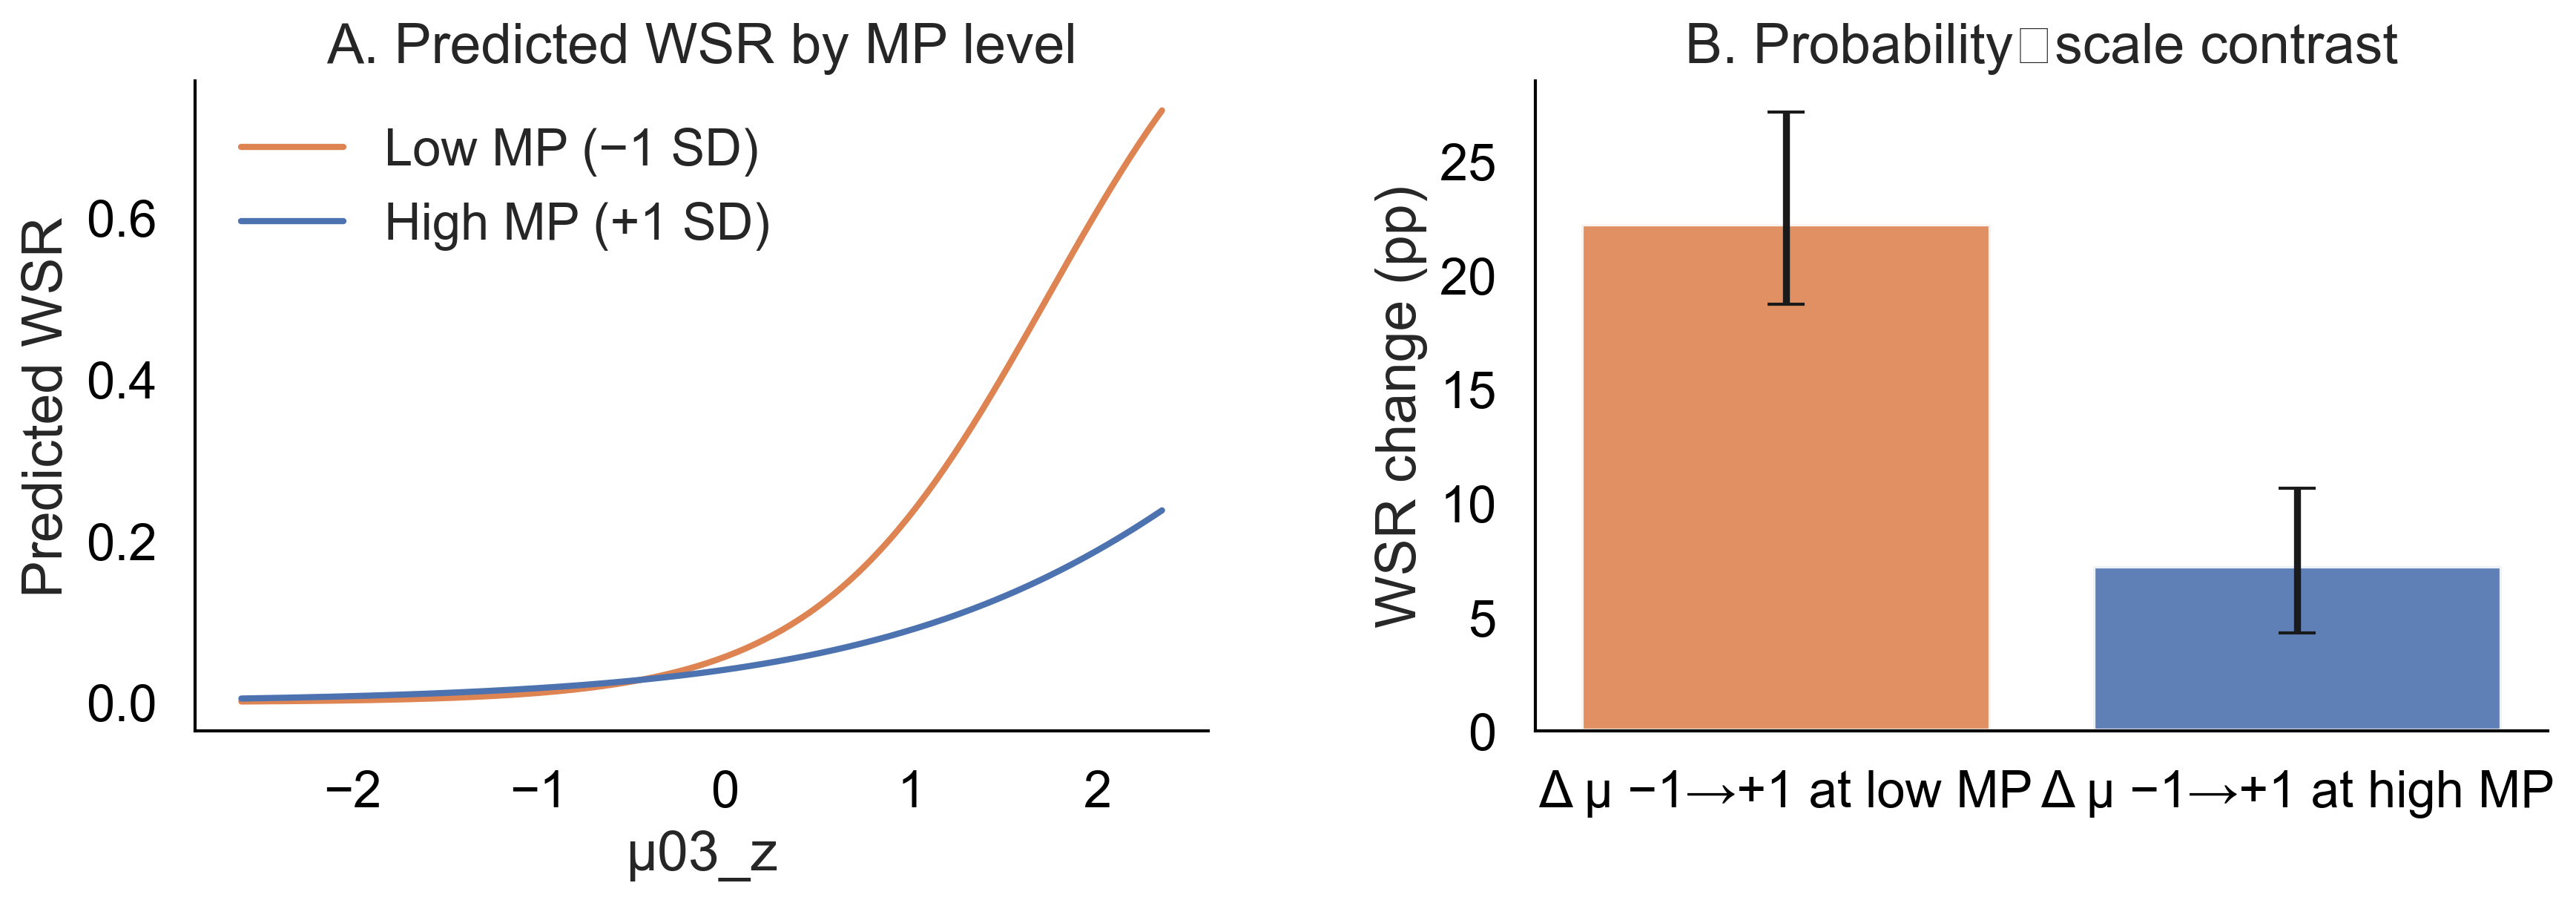

Interaction (global moderation): LRT χ²(1) = 2.38, p = 0.123
Practical contrast (probability scale):
  Δ_lowMP  = 0.2222 [0.1873, 0.2715], p_boot ≈ 0.000
  Δ_highMP = 0.0722 [0.0429, 0.1064], p_boot ≈ 0.000
  Attenuation = 0.1500 [0.1039, 0.2046], p_boot ≈ 0.000

WSR change (percentage points):
  Low MP: 22.22 pp
  High MP: 7.22 pp
  Buffer (Low − High): 15.00 pp

Interpretation: When volatility beliefs rise (−1→+1 SD), the predicted increase in WSR is larger at low MP than at high MP;
the difference (attenuation) is reported above with its bootstrap CI and approximate two-sided p from the bootstrap.


In [ ]:
# Planned comparison: Practical probability-scale contrast and visualizations
# Question: when beliefs about volatility increase (μ03_z from −1→+1),
# how much does win-switching (WSR) rise at low MP (−1 SD) vs high MP (+1 SD)?
# We compute that contrast under the full GLM (with μ03_z×MP_z), and show:
#   (A) GLM predicted curves across μ03_z at MP_z = −1 and +1 (controls at 0)
#   (B) A bar plot of the two changes (Δ_lowMP, Δ_highMP) with 1,000‑bootstrap CIs

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.utils import resample

full_glm = smf.glm('wsr_avg ~ mu03_z * MP_z + refl_z + gcog_z', data=df_model, family=sm.families.Binomial()).fit()

# --- Helper to predict probability at given (mu03_z, MP_z) with controls at mean (0 after z-scoring) ---
def predict_prob(mu_z: float, mp_z: float, model=full_glm) -> float:
    X = pd.DataFrame({
        'mu03_z': [mu_z],
        'MP_z': [mp_z],
        'refl_z': [0.0],
        'gcog_z': [0.0]
    })
    return float(model.predict(X))

# --- Compute the contrast on the fitted model ---
mu_lo, mu_hi = -1.0,  1.0   # −1 SD → +1 SD change in volatility
mp_lo, mp_hi = -1.0,  1.0   # low vs high MP levels

# Δ at low MP: P(μ=+1, MP=−1) − P(μ=−1, MP=−1)
delta_low = predict_prob(mu_hi, mp_lo) - predict_prob(mu_lo, mp_lo)
# Δ at high MP: P(μ=+1, MP=+1) − P(μ=−1, MP=+1)
delta_high = predict_prob(mu_hi, mp_hi) - predict_prob(mu_lo, mp_hi)
# Attenuation: Δ_low − Δ_high
attenuation = delta_low - delta_high

print('Point estimates (probability scale):')
print(f"Δ_lowMP (μ −1→+1 at MP −1)  = {delta_low:.4f}")
print(f"Δ_highMP (μ −1→+1 at MP +1) = {delta_high:.4f}")
print(f"Attenuation (Δ_low − Δ_high) = {attenuation:.4f}")

# --- Bootstrap CIs for Δ_low, Δ_high, and Attenuation ---
B = 1000
rng = np.random.default_rng(42)
boot_low, boot_high, boot_att = [], [], []
for b in range(B):
    # Resample rows with replacement
    df_b = df_model.sample(n=len(df_model), replace=True, random_state=int(rng.integers(0, 1e9)))
    try:
        glm_b = smf.glm('wsr_avg ~ mu03_z * MP_z + refl_z + gcog_z', data=df_b, family=sm.families.Binomial()).fit()
        # Compute deltas in bootstrap model
        def p_b(mu_z, mp_z):
            Xb = pd.DataFrame({'mu03_z':[mu_z],'MP_z':[mp_z],'refl_z':[0.0],'gcog_z':[0.0]})
            return float(glm_b.predict(Xb))
        d_low  = p_b(mu_hi, mp_lo) - p_b(mu_lo, mp_lo)
        d_high = p_b(mu_hi, mp_hi) - p_b(mu_lo, mp_hi)
        boot_low.append(d_low)
        boot_high.append(d_high)
        boot_att.append(d_low - d_high)
    except Exception:
        # In rare failures (e.g., separation), skip this replicate
        continue

# Percentile CIs
lo = lambda v: float(np.nanpercentile(v, 2.5))
hi = lambda v: float(np.nanpercentile(v, 97.5))
ci_low  = (lo(boot_low),  hi(boot_low))
ci_high = (lo(boot_high), hi(boot_high))
ci_att  = (lo(boot_att), hi(boot_att))

print('\nBootstrap 95% CIs (1,000 resamples):')
print(f"Δ_lowMP  95% CI = [{ci_low[0]:.4f}, {ci_low[1]:.4f}]")
print(f"Δ_highMP 95% CI = [{ci_high[0]:.4f}, {ci_high[1]:.4f}]")
print(f"Attenuation 95% CI = [{ci_att[0]:.4f}, {ci_att[1]:.4f}]")

# --- LRT stat (if reduced_glm not in scope, compute quickly for reporting) ---
try:
    reduced_glm
except NameError:
    reduced_glm = smf.glm('wsr_avg ~ mu03_z + MP_z + refl_z + gcog_z', data=df_model, family=sm.families.Binomial()).fit()
chi2_stat = 2.0 * (full_glm.llf - reduced_glm.llf)
df_diff = int(full_glm.df_model - reduced_glm.df_model)
from scipy.stats import chi2 as _chi2
p_lrt = float(_chi2.sf(chi2_stat, df_diff))

# --- Approximate bootstrap p-values for deltas (two-sided, percentile test) ---
prop = lambda arr: np.mean(np.array(arr) <= 0.0)
p_to = lambda arr: 2*min(np.mean(np.array(arr) <= 0.0), np.mean(np.array(arr) >= 0.0))
p_low  = p_to(boot_low)
p_high = p_to(boot_high)
p_att  = p_to(boot_att)

# --- Side-by-side figure: curves (left) and contrast bars (right) ---
mu_grid = np.linspace(df_model['mu03_z'].min(), df_model['mu03_z'].max(), 200)
probs_low  = [predict_prob(m, mp_lo) for m in mu_grid]
probs_high = [predict_prob(m, mp_hi) for m in mu_grid]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.0, 4.4))
fig.patch.set_facecolor('white')
# (A) Curves
ax1.plot(mu_grid, probs_low,  label='Low MP (−1 SD)',  color='#DD8452', linewidth=2)
ax1.plot(mu_grid, probs_high, label='High MP (+1 SD)', color='#4C72B0', linewidth=2)
ax1.set_xlabel('μ03_z')
ax1.set_ylabel('Predicted WSR')
ax1.set_title('A. Predicted WSR by MP level')
ax1.legend(frameon=False, loc='upper left')
# Style axes: white face, black left/bottom spines, no grid
ax1.grid(False)
ax1.set_facecolor('white')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_color('black'); ax1.spines['bottom'].set_color('black')
ax1.spines['left'].set_linewidth(1.0); ax1.spines['bottom'].set_linewidth(1.0)
ax1.tick_params(axis='both', colors='black')

# (B) Bars with bootstrap CIs (values in percentage points)
vals_pp = [delta_low*100.0, delta_high*100.0]
errs_pp = [
    [ (delta_low - ci_low[0])*100.0,  (ci_low[1]  - delta_low)*100.0 ],
    [ (delta_high - ci_high[0])*100.0, (ci_high[1] - delta_high)*100.0 ]
]
labels = ['Δ μ −1→+1 at low MP', 'Δ μ −1→+1 at high MP']
bar_colors = ['#DD8452','#4C72B0']
ax2.bar(labels, vals_pp, yerr=np.array(errs_pp).T, capsize=6, color=bar_colors, alpha=0.9)
ax2.set_ylabel('WSR change (pp)')
ax2.set_title('B. Probability‑scale contrast')
# Style axes: white face, black left/bottom spines, no grid
ax2.grid(False)
ax2.set_facecolor('white')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_color('black'); ax2.spines['bottom'].set_color('black')
ax2.spines['left'].set_linewidth(1.0); ax2.spines['bottom'].set_linewidth(1.0)
ax2.tick_params(axis='both', colors='black')

plt.tight_layout(w_pad=3.0); plt.show()

# Print stats neatly
print('Interaction (global moderation): LRT χ²({}) = {:.2f}, p = {:.3f}'.format(df_diff, chi2_stat, p_lrt))
print('Practical contrast (probability scale):')
print('  Δ_lowMP  = {:.4f} [{:.4f}, {:.4f}], p_boot ≈ {:.3f}'.format(delta_low,  ci_low[0],  ci_low[1],  p_low))
print('  Δ_highMP = {:.4f} [{:.4f}, {:.4f}], p_boot ≈ {:.3f}'.format(delta_high, ci_high[0], ci_high[1], p_high))
print('  Attenuation = {:.4f} [{:.4f}, {:.4f}], p_boot ≈ {:.3f}'.format(attenuation, ci_att[0], ci_att[1], p_att))

# Explicit percentage-point readout for the figure labels
print('\nWSR change (percentage points):')
print('  Low MP: {:.2f} pp'.format(delta_low*100))
print('  High MP: {:.2f} pp'.format(delta_high*100))
print('  Buffer (Low − High): {:.2f} pp'.format((delta_low - delta_high)*100))

print('\nInterpretation: When volatility beliefs rise (−1→+1 SD), the predicted increase in WSR is larger at low MP than at high MP;')
print('the difference (attenuation) is reported above with its bootstrap CI and approximate two-sided p from the bootstrap.')


In [ ]:
# Demographics — distribution (all categories) and global tests of MP differences
# Stats: Gender (Female vs Male); Race (White, Black, Asian, Multiracial)

import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
from statsmodels.stats.oneway import anova_oneway

# Clean categorical labels directly on df
_clean = lambda x: (str(x).strip().title() if pd.notna(x) else np.nan)
if 'gender' in df.columns:
    df['gender_clean'] = df['gender'].apply(_clean)
    # Collapse Other + Decline to answer, keep Not specified separate
    def _map_gender(val):
        if pd.isna(val):
            return 'Not specified'
        s = str(val).strip().lower()
        if s == 'female':
            return 'Female'
        if s == 'male':
            return 'Male'
        if s in ['other','decline to answer','prefer not to say']:
            return 'Other/Declined'
        # Any remaining coded value goes to Other/Declined to preserve N
        return 'Other/Declined'
    df['gender_std'] = df['gender'].apply(_map_gender)

if 'race' in df.columns:
    df['race_clean'] = df['race'].apply(_clean)
    def _map_race(val):
        if pd.isna(val):
            return 'Not specified'
        s = str(val).strip().lower()
        # Match exact labels used in your data schema
        if s == 'white':
            return 'White'
        if s in ['black','black or african american','african american']:
            return 'Black or African American'
        if s == 'asian':
            return 'Asian'
        if s in ['american indian or alaska native','american indian','alaska native']:
            return 'American Indian or Alaska Native'
        if s == 'multiracial':
            return 'Multiracial'
        if ',' in s:  # comma-separated multi-race => Multiracial
            return 'Multiracial'
        return 'Not specified'
    df['race_std'] = df['race_clean'].apply(_map_race)

total_n = len(df)

# --- Full distribution tables ---
# Gender distribution (Female, Male, Other/Declined, Not specified)
gender_source = 'gender_std' if 'gender_std' in df.columns else 'gender_clean'
gender_order = ['Female','Male','Other/Declined','Not specified']
gender_counts_all = df[gender_source].fillna('Not specified').value_counts().reindex(gender_order).dropna()
gender_tbl = pd.DataFrame({
    'Variable': ['Gender']*len(gender_counts_all),
    'Group': gender_counts_all.index,
    'N': gender_counts_all.values,
    'Percent': (gender_counts_all.values/total_n*100.0).round(2)
})

# Race distribution (standardized groups)
race_source = 'race_std' if 'race_std' in df.columns else 'race_clean'
race_order = ['White','Black or African American','Asian','American Indian or Alaska Native','Multiracial','Not specified']
race_counts_all = df[race_source].fillna('Not specified').value_counts().reindex(race_order).dropna()
race_tbl = pd.DataFrame({
    'Variable': ['Race']*len(race_counts_all),
    'Group': race_counts_all.index,
    'N': race_counts_all.values,
    'Percent': (race_counts_all.values/total_n*100.0).round(2)
})

# --- Global tests on specified subsets ---
# Gender test: Female vs Male (Welch t)
df_gender = df[df[gender_source].isin(['Female','Male']) & df['MP_avg'].notna()].copy()
x_f = df_gender.loc[df_gender[gender_source]=='Female','MP_avg'].dropna()
x_m = df_gender.loc[df_gender[gender_source]=='Male','MP_avg'].dropna()
_t, _p = ttest_ind(x_f, x_m, equal_var=False)
s1, s2 = x_f.var(ddof=1), x_m.var(ddof=1)
n1, n2 = len(x_f), len(x_m)
df_w = (s1/n1 + s2/n2)**2 / ((s1**2)/((n1**2)*(n1-1)) + (s2**2)/((n2**2)*(n2-1)))

# Race test: White, Black or African American, Asian, Multiracial (Welch ANOVA)
race_keep = ['White','Black or African American','Asian','Multiracial']
df_race = df[df[race_source].isin(race_keep) & df['MP_avg'].notna()].copy()
# Keep only groups with n>=2 to avoid NaNs in Welch
race_groups = {c: df_race.loc[df_race[race_source]==c, 'MP_avg'].dropna().values for c in race_keep}
race_groups = {k:v for k,v in race_groups.items() if len(v) >= 2}
if len(race_groups) >= 2:
    res = anova_oneway(list(race_groups.values()), use_var='unequal')
    F_welch = float(res.statistic); p_welch = float(res.pvalue)
    df_num = len(race_groups) - 1; df_den = float(res.df_denom)
    race_test_str = 'Race ({}), Welch F({:.0f}, {:.1f}) = {:.2f}, p = {:.3f}'.format(
        '/'.join(race_groups.keys()), df_num, df_den, F_welch, p_welch)
else:
    F_welch = np.nan; p_welch = np.nan; df_num = np.nan; df_den = np.nan
    race_test_str = 'Race: insufficient group sizes for global test (need ≥2 groups with n≥2)'

# --- Assemble and print ---
blank = pd.DataFrame({'Variable':[''], 'Group':[''], 'N':[''], 'Percent':['']})
demo_tbl = pd.concat([gender_tbl, blank, race_tbl], ignore_index=True)

print('Supplementary Table — Demographic distribution (N = {})'.format(total_n))
print(demo_tbl.to_string(index=False))

print('\nGlobal tests of MP differences (unadjusted):')
print('  Gender (Female vs Male), Welch t({:.1f}) = {:.2f}, p = {:.3f}'.format(df_w, _t, _p))
print('  ' + race_test_str)

print('\nThe distribution includes all recorded categories (with Other + Declined collapsed). '\
      'Global tests use prespecified comparisons; race test excludes groups with n < 2 to ensure valid inference.')



Supplementary Table — Demographic distribution (N = 486)
Variable                            Group      N Percent
  Gender                           Female  193.0   39.71
  Gender                             Male  289.0   59.47
  Gender                   Other/Declined    4.0    0.82
                                                        
    Race                            White    367   75.51
    Race        Black or African American     59   12.14
    Race                            Asian     30    6.17
    Race American Indian or Alaska Native      2    0.41
    Race                      Multiracial     20    4.12
    Race                    Not specified      8    1.65

Global tests of MP differences (unadjusted):
  Gender (Female vs Male), Welch t(421.7) = 0.90, p = 0.368
  Race (White/Black or African American/Asian/Multiracial), Welch F(3, 55.0) = 7.87, p = 0.000

Reader notes: The distribution includes all recorded categories (with Other + Declined collapsed). Global tests us

In [ ]:
# Covariates — concise distribution table (CRT, general cognition, reflection length)
import numpy as np
import pandas as pd

cov_map = {
    'CRT': 'CRT_avg',
    'General cognition': 'general_cognition',
    'Reflection length': 'reflection_length'
}

rows = []
for label, col in cov_map.items():
    s = df[col].dropna().astype(float)
    q1, med, q3 = np.percentile(s, [25, 50, 75])
    rows.append({
        'Variable': label,
        'Mean': s.mean(),
        'SD': s.std(ddof=1),
        'Min': s.min(),
        'Q1': q1,
        'Median': med,
        'Q3': q3,
        'Max': s.max()
    })

cov_tbl = pd.DataFrame(rows)

# Rounding
fmt_cols = ['Mean','SD','Min','Q1','Median','Q3','Max']
for c in fmt_cols:
    cov_tbl[c] = cov_tbl[c].map(lambda v: f"{v:.2f}")

print('Supplementary Table — Covariates distribution (CRT, general cognition, reflection length)')
print(cov_tbl.to_string(index=False))



Supplementary Table — Covariates distribution (CRT, general cognition, reflection length)
         Variable   Mean     SD  Min    Q1 Median     Q3     Max
              CRT   0.62   0.39 0.00  0.33   0.67   1.00    1.00
General cognition   2.43   0.72 0.00  2.00   2.50   3.00    4.00
Reflection length 110.53 141.17 3.00 36.25  81.00 147.75 2313.00


Top reflection_length cases:
 reflection_length  MP_avg  mu03_avg  wsr_avg       mturk_id
              2313    3.32  1.001195 0.028571 A2VFEDAK5C1E1O
               715    3.20 -1.369217 0.000000 A3LT7W355XOAKF
               578    3.32  0.967205 0.240485 A2GXLM74C7BDI8
               501    3.54 -1.943488 0.000000 A14WLAP6TCEKO0
               488    3.52 -1.227841 0.000000  AKLG79EPGKTDP

Correlations (covariates × {MP_avg, mu03_avg, wsr_avg}):
        covariate variable  pearson_r  p_value   n
          CRT_avg   MP_avg      0.316    0.000 486
          CRT_avg mu03_avg     -0.253    0.000 486
          CRT_avg  wsr_avg     -0.274    0.000 486
general_cognition   MP_avg     -0.016    0.717 486
general_cognition mu03_avg     -0.023    0.620 486
general_cognition  wsr_avg      0.026    0.564 486
reflection_length   MP_avg      0.532    0.000 486
reflection_length mu03_avg     -0.072    0.114 486
reflection_length  wsr_avg     -0.169    0.000 486


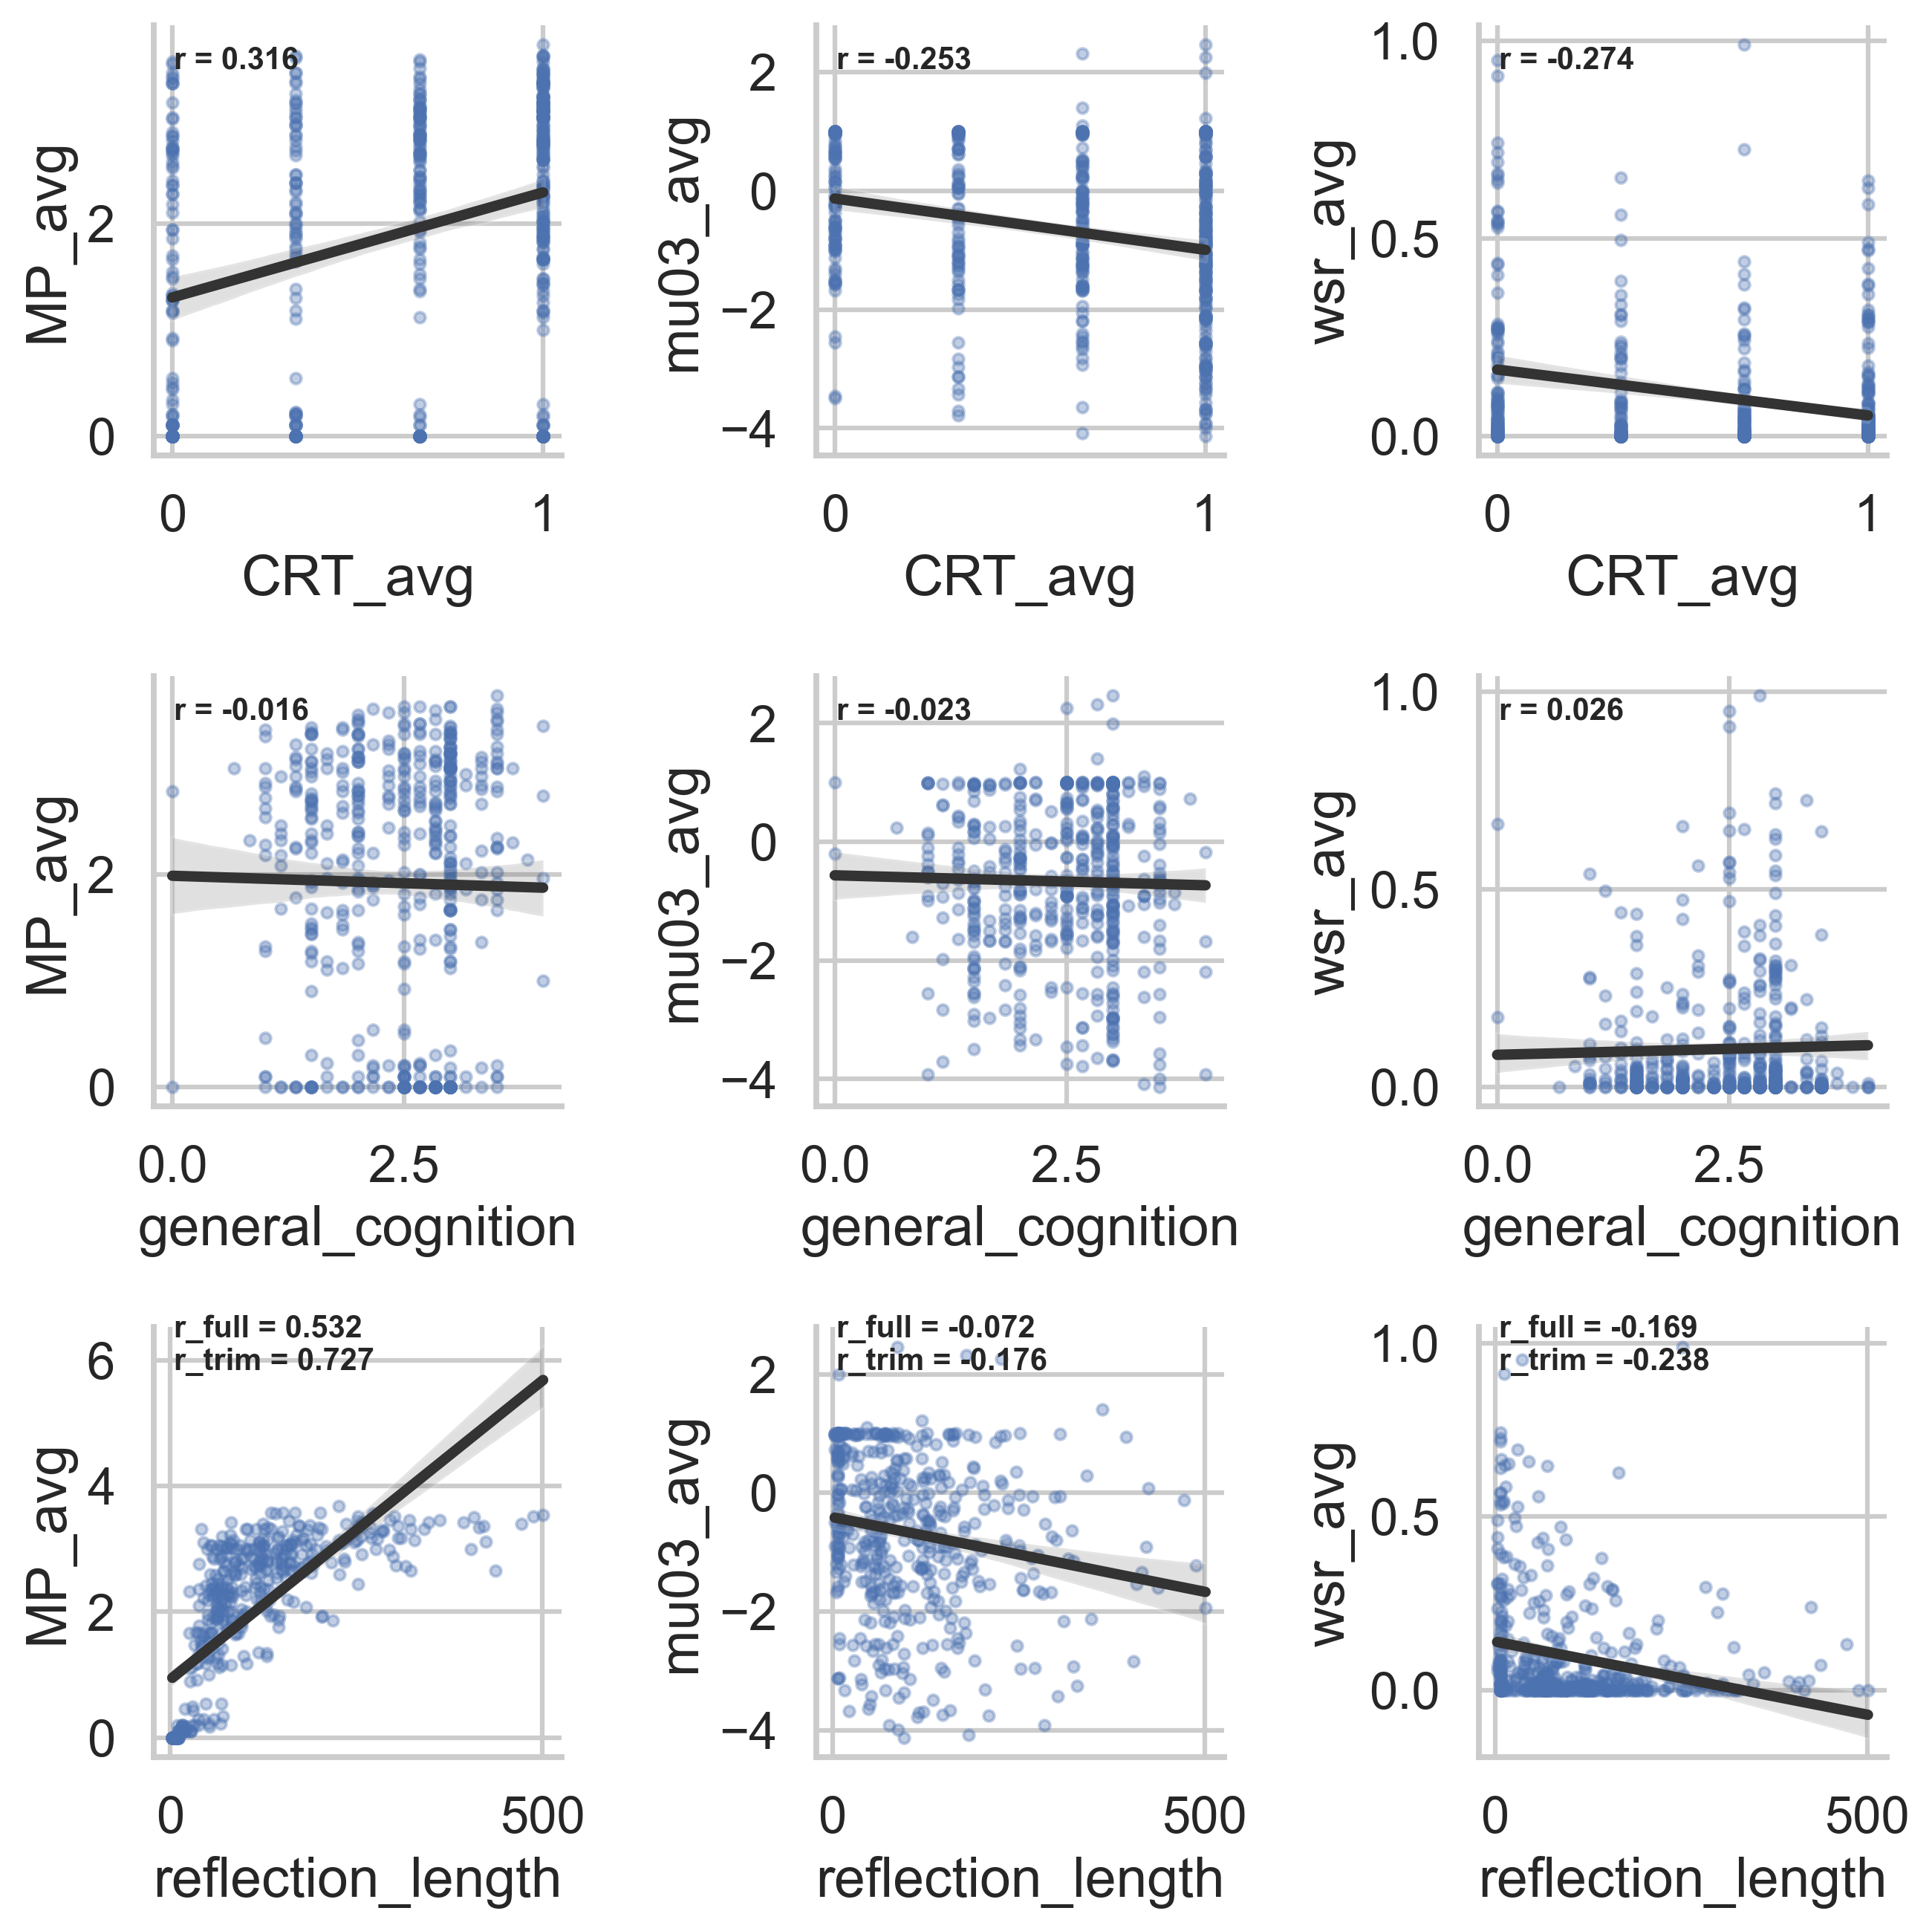


Summary:
 - reflection_length vs MP_avg: r = 0.532, p = 0.000 (n = 486)
 - CRT_avg vs MP_avg: r = 0.316, p = 0.000 (n = 486)
 - CRT_avg vs wsr_avg: r = -0.274, p = 0.000 (n = 486)
 - Reflection length outlier cutoff ≈ 545.3; plots annotate r_full and r_trim for those panels.


In [ ]:
# Covariates — correlations and reflection-length outlier preview (with summary)
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

covariates = ['CRT_avg','general_cognition','reflection_length']
outcomes   = ['MP_avg','mu03_avg','wsr_avg']

# Detect an ID column if available
id_col = next((c for c in ['mturk_id','participant_id','worker_id','user_id','id','prolific_id'] if c in df.columns), None)

# --- Top reflection-length cases (preview) ---
cols_to_show = ['reflection_length','MP_avg','mu03_avg','wsr_avg'] + ([id_col] if id_col else [])
print('Top reflection_length cases:')
print(df[cols_to_show].sort_values('reflection_length', ascending=False).head(5).to_string(index=False))

# --- Correlations table (Pearson r with p-values) ---
rows = []
for c in covariates:
    for v in outcomes:
        if c in df.columns and v in df.columns:
            dd = df[[c, v]].dropna()
            if len(dd) > 1:
                r, p = pearsonr(dd[c].astype(float), dd[v].astype(float))
                rows.append({'covariate': c, 'variable': v, 'pearson_r': r, 'p_value': p, 'n': len(dd)})
cor_tbl = pd.DataFrame(rows)
print('\nCorrelations (covariates × {MP_avg, mu03_avg, wsr_avg}):')
if not cor_tbl.empty:
    print(cor_tbl.to_string(index=False, float_format=lambda x: f"{x:.3f}"))
else:
    print('No complete pairs found.')

# --- 3×3 mini-plot with r annotations; trim reflection_length outliers for a sensitivity r ---
# Define outlier cutoff for trimming (max of Tukey 1.5×IQR and 99.5th percentile)
rl = df['reflection_length'].dropna().astype(float)
if len(rl) > 0:
    q1, q3 = rl.quantile([0.25, 0.75])
    iqr = q3 - q1
    hi_tukey = q3 + 1.5*iqr
    hi_p995 = rl.quantile(0.995)
    hi_cut = max(hi_tukey, hi_p995)
    mask_keep = df['reflection_length'] <= hi_cut
else:
    mask_keep = pd.Series(False, index=df.index)

fig, axes = plt.subplots(len(covariates), len(outcomes), figsize=(9, 9))
for i, rvar in enumerate(covariates):
    for j, cvar in enumerate(outcomes):
        ax = axes[i, j]
        pair_full = df[[rvar, cvar]].dropna()
        pair_trim = df.loc[mask_keep, [rvar, cvar]].dropna() if rvar == 'reflection_length' else pair_full
        # r values
        r_full = pair_full[rvar].corr(pair_full[cvar]) if len(pair_full) > 1 else np.nan
        r_trim = pair_trim[rvar].corr(pair_trim[cvar]) if len(pair_trim) > 1 else np.nan
        plot_df = pair_trim if rvar == 'reflection_length' else pair_full
        sns.regplot(x=rvar, y=cvar, data=plot_df, scatter_kws={'alpha':0.35, 's':12}, line_kws={'color':'#333'}, ax=ax)
        label = f"r = {r_full:.3f}" if rvar != 'reflection_length' else f"r_full = {r_full:.3f}\nr_trim = {r_trim:.3f}"
        ax.text(0.05, 0.9, label, transform=ax.transAxes, fontsize=10, fontweight='bold')
        ax.set_xlabel(rvar)
        ax.set_ylabel(cvar)
        ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.tight_layout(); plt.show()

# --- Summary ---
print('\nSummary:')
# Highlight key correlations 
def _desc(row):
    return f"{row['covariate']} vs {row['variable']}: r = {row['pearson_r']:.3f}, p = {row['p_value']:.3f} (n = {int(row['n'])})"
if not cor_tbl.empty:
    # Order by absolute r
    top = cor_tbl.reindex(cor_tbl['pearson_r'].abs().sort_values(ascending=False).index)[:3]
    for _, row in top.iterrows():
        print(' - ' + _desc(row))
    if 'reflection_length' in df.columns:
        # Report trimming note
        if len(rl) > 0:
            print(f" - Reflection length outlier cutoff ≈ {hi_cut:.1f}; plots annotate r_full and r_trim for those panels.")
else:
    print('No correlations available to summarize.')



In [ ]:
# Covariates-only Binomial GLM (logit): wsr_avg ~ reflection_length + general_cognition
# Prints Odds Ratios, Average Marginal Effects, and a concise summary of implications

import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats as _scistats

# Keep complete cases
df_glm = df.dropna(subset=['wsr_avg','reflection_length','general_cognition'])

# Fit GLM
glm_cov = smf.glm('wsr_avg ~ reflection_length + general_cognition', data=df_glm, family=sm.families.Binomial()).fit()

# Odds ratios with 95% CI
params = glm_cov.params
conf = glm_cov.conf_int()
OR = np.exp(params)
OR_lo = np.exp(conf[0])
OR_hi = np.exp(conf[1])
or_table = pd.DataFrame({'term': OR.index,
                         'OR': OR.values,
                         'CI_lo': OR_lo.values,
                         'CI_hi': OR_hi.values,
                         'p': glm_cov.pvalues.values})
print('Covariates-only GLM — Odds Ratios (95% CI):')
print(or_table.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

# Average Marginal Effects (probability scale)
mfx = glm_cov.get_margeff(at='overall')
sf = mfx.summary_frame().reset_index()
# Robust column detection
_lower = {c.lower().strip(): c for c in sf.columns}
term_col = 'index' if 'index' in sf.columns else sf.columns[0]
ame_col = _lower.get('dy/dx') or _lower.get('margeff') or _lower.get('derivative')
se_col = _lower.get('std. err.') or _lower.get('std err') or _lower.get('std_err')
p_col = _lower.get('p>|z|') or _lower.get('p>|t|') or _lower.get('p-value')
if p_col is None and 'z' in _lower:
    zvals = sf[_lower['z']].astype(float).values
    sf['p'] = 2 * (1 - _scistats.norm.cdf(np.abs(zvals)))
    p_col = 'p'
keep_cols = [c for c in [term_col, ame_col, se_col, p_col] if c in sf.columns]
ames = sf[keep_cols].copy()
ames.columns = ['term','AME','SE','p']
print('\nCovariates-only GLM — Average Marginal Effects (probability scale):')
print(ames.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

# Concise reader notes
def pick_row(tbl, name):
    m = tbl.loc[tbl['term']==name]
    return m.iloc[0] if not m.empty else None

rl_or = pick_row(or_table, 'reflection_length')
rl_ame = pick_row(ames, 'reflection_length')
co_or = pick_row(or_table, 'general_cognition')
co_ame = pick_row(ames, 'general_cognition')

msgs = []
for label, r_or, r_ame in [
    ('reflection_length', rl_or, rl_ame),
    ('general_cognition', co_or, co_ame)
]:
    if r_or is not None and r_ame is not None:
        sig = 'significant' if float(r_or['p']) < 0.05 else 'not significant'
        msgs.append(
            f"{label}: OR={r_or['OR']:.2f} (95% CI {r_or['CI_lo']:.2f}–{r_or['CI_hi']:.2f}), p={r_or['p']:.3f}; "
            f"AME={r_ame['AME']:.4f} (p={r_ame['p']:.3f})"
        )

print('\nReader notes (covariates-only model):')
for m in msgs:
    print(' - ' + m)
if rl_ame is not None and co_ame is not None:
    any_sig = (float(rl_or['p']) < 0.05) or (float(co_or['p']) < 0.05)
    if any_sig:
        print(' - One or both covariates show an association with WSR when entered alone; magnitudes are reported as AMEs on the probability scale.')
    else:
        print(' - Both covariates are near-null in the covariates-only model, suggesting verbosity and general cognition alone do not explain WSR.')
print(' - Implication: These results support treating verbosity and general cognition as controls in the main GLM, rather than primary drivers of win-switching.')



Covariates-only GLM — Odds Ratios (95% CI):
             term     OR  CI_lo  CI_hi      p
        Intercept 0.1520 0.0480 0.4807 0.0013
reflection_length 0.9940 0.9896 0.9985 0.0088
general_cognition 1.0678 0.6947 1.6414 0.7648

Covariates-only GLM — Average Marginal Effects (probability scale):
             term     AME     SE      p
reflection_length -0.0005 0.0002 0.0106
general_cognition  0.0056 0.0187 0.7648

Reader notes (covariates-only model):
 - reflection_length: OR=0.99 (95% CI 0.99–1.00), p=0.009; AME=-0.0005 (p=0.011)
 - general_cognition: OR=1.07 (95% CI 0.69–1.64), p=0.765; AME=0.0056 (p=0.765)
 - One or both covariates show an association with WSR when entered alone; magnitudes are reported as AMEs on the probability scale.
 - Implication: These results support treating verbosity and general cognition as controls in the main GLM, rather than primary drivers of win-switching.
